## **DataHack by IIT Guwahati: June 2024**
Hackathon conducted by Consulting and Analytics Club, IIT Guwahati in collaboration with `GeeksforGeeks`.


## **Objective:**

The Goal is to predict how likely individuals are to receive their xyz and seasonal fluvaccines. Specifically, we'll be predicting two probabilities: one for xyz_vaccine and one for seasonal_vaccine.
<br><br>
`Submitted by Karan Rabidas, B.Tech, IIT Guwahati`
k.rabidas@iitg.ac.in

<hr><hr>

# **Load Libraries**

In [1]:
# Utilities
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)                      # Set the option to display all columns in pandas

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering
from sklearn.feature_selection import mutual_info_classif as mic  # Import mutual_info_classif for feature selection
from sklearn.impute import SimpleImputer                          # Import SimpleImputer for missing value imputation

# Modeling
from sklearn.model_selection import KFold                       # Import KFold for cross-validation
from sklearn.metrics import roc_auc_score as ras                # Import roc_auc_score for evaluation metric
from sklearn.model_selection import cross_val_score             # Import cross_val_score for cross-validation

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


# **1. Data Wrangling**



### Loading the dataset from github repository in the files section of the notebook.

In [2]:
#upload the datasets automatically from github
!mkdir data/
!wget https://raw.githubusercontent.com/karan-gh/Predicting-Vaccinated-Probability/main/training_set_features.csv

!mkdir data/
!wget https://raw.githubusercontent.com/karan-gh/Predicting-Vaccinated-Probability/main/training_set_labels.csv

!mkdir data/
!wget https://raw.githubusercontent.com/karan-gh/Predicting-Vaccinated-Probability/main/submission_format.csv

!mkdir data/
!wget https://raw.githubusercontent.com/karan-gh/Predicting-Vaccinated-Probability/main/test_set_features.csv


--2024-06-17 01:47:31--  https://raw.githubusercontent.com/karan-gh/Predicting-Vaccinated-Probability/main/training_set_features.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4645840 (4.4M) [text/plain]
Saving to: ‘training_set_features.csv’

training_set_featur 100%[===================>]   4.43M  18.0MB/s    in 0.2s    

2024-06-17 01:47:32 (18.0 MB/s) - ‘training_set_features.csv’ saved [4645840/4645840]

mkdir: cannot create directory ‘data/’: File exists
--2024-06-17 01:47:32--  https://raw.githubusercontent.com/karan-gh/Predicting-Vaccinated-Probability/main/training_set_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.g

### **1.1 Load Dataset**

In [3]:
train_feature = pd.read_csv("/content/training_set_features.csv", index_col="respondent_id")
train_label = pd.read_csv("/content/training_set_labels.csv", index_col="respondent_id")
sample_submission = pd.read_csv("/content/submission_format.csv", index_col="respondent_id")

In [4]:
train = train_feature.merge(train_label, on='respondent_id') # Merge train_feature and train_label
test = pd.read_csv("/content/test_set_features.csv", index_col="respondent_id")

In [5]:
train.head()

,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


### **1.2 Data Inspection**

In [6]:
print(f"Train shape: {train.shape}")  # See number of rows and columns in train dataset
print(f"Test shape: {test.shape}")    # See number of rows and columns in test dataset

Train shape: (26707, 37)
Test shape: (26708, 35)


In [7]:
train.info() # Displays a summary of the dataframe

<class 'pandas.core.frame.DataFrame'>
Index: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   xyz_concern                  26615 non-null  float64
 1   xyz_knowledge                26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_xyz              24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker        

Creating a function to evaluate the missing value proportions in the train and test datasets.

In [8]:
def missing_values(train, test):
    miss_perc_df = pd.DataFrame (
        index=['train_miss','test_miss'],   # Set index of dataframe
        columns=test.columns,               # Set columns of dataframe
    )

    # Loop through the columns of the "test" dataframe and calculate the percentage of missing values for both the "train" and "test" dataframes
    for i, col in enumerate(test.columns):
        miss_perc_df.loc['train_miss', col] = np.round(train.isna().sum()[i] / train[col].shape[0] * 100, 2)  # Calculate missing values in train dataset
        miss_perc_df.loc['test_miss', col] = np.round(test.isna().sum()[i] / test[col].shape[0] * 100, 2)     # Calculate missing values in test dataset

    # Convert the values in the "miss_perc_df" dataframe to strings and append a "%" sign
    miss_perc_df = miss_perc_df.astype(str) + "%"
    return miss_perc_df

In [9]:
missing_values(train, test)

,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
train_miss,0.34%,0.43%,0.27%,0.78%,0.07%,0.16%,0.33%,0.31%,0.48%,8.09%,8.09%,3.64%,3.07%,3.01%,45.96%,1.46%,1.45%,1.48%,1.73%,1.92%,2.01%,0.0%,5.27%,0.0%,0.0%,16.56%,5.27%,7.65%,5.48%,0.0%,0.0%,0.93%,0.93%,49.91%,50.44%
test_miss,0.32%,0.46%,0.3%,0.8%,0.07%,0.15%,0.27%,0.31%,0.48%,8.09%,8.09%,3.49%,3.04%,2.95%,45.78%,1.49%,1.42%,1.4%,1.69%,1.87%,1.95%,0.0%,5.27%,0.0%,0.0%,16.84%,5.4%,7.62%,5.51%,0.0%,0.0%,0.84%,0.84%,49.7%,50.27%


From the given dataframe, we can gather the following information:
* The columns `health_insurance`, `employment_industry`, and `employment_occupation` contain a significant number of missing values.
* The `income_poverty` column also has a considerable amount of missing data.
* The `doctor_recc_xyz` and `doctor_recc_seasonal` columns share the same proportion of missing values.

In [10]:
ordinal_cols = train.select_dtypes("float64").columns.to_list()
object_cols = train.select_dtypes("object").columns.to_list()

behavioral_cols = ["behavioral_antiviral_meds", "behavioral_avoidance", "behavioral_face_mask", "behavioral_wash_hands",
                   "behavioral_large_gatherings", "behavioral_outside_home", "behavioral_touch_face"]

opinion_cols = ["opinion_xyz_vacc_effective", "opinion_xyz_risk", "opinion_xyz_sick_from_vacc",
                "opinion_seas_vacc_effective", "opinion_seas_risk", "opinion_seas_sick_from_vacc"]

In [11]:
# Ordinal columns
ord_summary = train.loc[:, ordinal_cols].describe()
pd.concat([ord_summary, train[ordinal_cols].mode()]).rename(index={0: "mean"})

,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000
mean,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,1.000000,1.000000,0.000000


In [12]:
# Nominal columns
train.loc[:, object_cols].describe()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


In [13]:
print("Ordinal columns:", len(ordinal_cols))
print("Nominal columns:", len(object_cols))

Ordinal columns: 23
Nominal columns: 12


In [14]:
nan_to_miss = train.copy()

# Replace all missing values in the 'nan_to_miss' dataframe with the string "Missing"
nan_to_miss.fillna("Missing", inplace=True)

In [15]:
train[train["education"].isna()].tail()

,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,xyz_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26549,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,35 - 44 Years,NaN,White,Female,NaN,NaN,NaN,NaN,oxchjgsf,Non-MSA,1.0,2.0,NaN,NaN,0,1
26608,2.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65+ Years,NaN,Other or Multiple,Female,NaN,NaN,NaN,NaN,lrircsnp,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,0
26639,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,NaN,4.0,4.0,4.0,4.0,1.0,4.0,65+ Years,NaN,Hispanic,Male,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,0
26672,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18 - 34 Years,NaN,Black,Female,NaN,NaN,NaN,NaN,fpwskwrf,"MSA, Principle City",NaN,NaN,NaN,NaN,0,1
26675,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,NaN,4.0,2.0,2.0,4.0,4.0,2.0,45 - 54 Years,NaN,White,Male,NaN,NaN,NaN,NaN,kbazzjca,Non-MSA,1.0,1.0,NaN,NaN,0,1


In [16]:
# Computes a frequency table or contingency table showing the distribution of two categorical variables in the DataFrame
pd.crosstab(nan_to_miss["doctor_recc_xyz"], nan_to_miss["doctor_recc_seasonal"])

doctor_recc_seasonal,0.0,1.0,Missing
doctor_recc_xyz,,,
0.0,15659,3480,0
1.0,794,4614,0
Missing,0,0,2160


In [17]:
pd.crosstab(nan_to_miss["employment_status"], nan_to_miss["employment_industry"])

employment_industry,Missing,arjwrbjb,atmlpfrs,cfqqtusy,dotnnunm,fcxhlnwr,haxffmxo,ldnlellj,mcubkhph,mfikgejo,msuufmds,nduyfdeo,phxvnwax,pxcmvdjn,qnlwzans,rucpziij,saaquncn,vjjrobsf,wlfvacwt,wxleyezf,xicduogh,xqicxuve
employment_status,,,,,,,,,,,,,,,,,,,,,,
Employed,183,871,926,325,201,2468,148,1231,275,614,124,286,89,1037,13,523,338,527,215,1804,851,511
Missing,1463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Not in Labor Force,10231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Unemployed,1453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
pd.crosstab(nan_to_miss["employment_status"], nan_to_miss["employment_occupation"])

employment_occupation,Missing,bxpfxfdn,ccgxvspp,cmhcxjea,dcjcmpih,dlvbwzss,emcorrxb,haliazsg,hfxkjkmi,hodpvpew,kldqjyjy,mxkfnird,oijqvulv,pvmttkik,qxajmpny,rcertsgn,tfqavkke,ukymxvdu,uqqtjvyb,vlluhbov,xgwztkwe,xqwwgdyp,xtkaffoo,xzmlyyjv
employment_status,,,,,,,,,,,,,,,,,,,,,,,,
Employed,323,331,341,1247,148,227,1270,296,766,208,469,1509,344,98,548,276,388,372,452,354,1082,485,1778,248
Missing,1463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Not in Labor Force,10231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Unemployed,1453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **1.3 Handling Missing Values**

In [19]:
for df in [train, test]:
    df['doctor_recc_xyz'].fillna(2.0, inplace=True)
    df['doctor_recc_seasonal'].fillna(2.0, inplace=True)
    df['health_insurance'].fillna(2.0, inplace=True)

    df["education"].fillna("Unknown", inplace=True)
    df["marital_status"].fillna("Unknown", inplace=True)
    df["rent_or_own"].fillna("Unknown", inplace=True)
    df["income_poverty"].fillna("Unknown", inplace=True)

In [20]:
for df in [train, test]:
    df['employment_status'].fillna("Not in Labor Force", inplace=True);

In [21]:
for df in [train, test]:
    for row in range(df.index[0], df.index[-1]+1):  # Iterate over the rows of the DataFrame.
        if (df.loc[row, "employment_status"] == "Not in Labor Force") or (df.loc[row, "employment_status"] == "Unemployed"):
            df.loc[row, "employment_occupation"] = "None"  # Set the value of 'employment_occupation' to "None" for the current row.
            df.loc[row, "employment_industry"] = "None"  # Set the value of 'employment_industry' to "None" for the current row.

In [22]:
for df in [train, test]:
    df[opinion_cols] = df[opinion_cols].fillna(3.0)

In [23]:
missing_values(train, test)

,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
train_miss,0.34%,0.43%,0.27%,0.78%,0.07%,0.16%,0.33%,0.31%,0.48%,0.0%,0.0%,3.64%,3.07%,3.01%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.93%,0.93%,0.69%,1.21%
test_miss,0.32%,0.46%,0.3%,0.8%,0.07%,0.15%,0.27%,0.31%,0.48%,0.0%,0.0%,3.49%,3.04%,2.95%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.84%,0.84%,0.75%,1.31%


Handling the remaining missing values in both the train and test datasets:

In [24]:
imputer = SimpleImputer(strategy='most_frequent')  # Create an instance of SimpleImputer with 'most_frequent' strategy.

# Ordinal Columns
train[ordinal_cols] = imputer.fit_transform(train[ordinal_cols])  # Fill missing values in ordinal columns of 'train' DataFrame using the fitted imputer.
test[ordinal_cols] = imputer.transform(test[ordinal_cols])  # Fill missing values in ordinal columns of 'test' DataFrame using the fitted imputer.

# Nominal Columns
train[object_cols] = imputer.fit_transform(train[object_cols])  # Fill missing values in nominal columns of 'train' DataFrame using the fitted imputer.
test[object_cols] = imputer.transform(test[object_cols])  # Fill missing values in nominal columns of 'test' DataFrame using the fitted imputer.

In [25]:
missing_values(train, test)

,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
train_miss,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
test_miss,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


### **1.4 Handling Other Issues**

In [26]:
train[ordinal_cols] = train[ordinal_cols].astype("int64") # Convert train[ordinal_cols] to integer
test[ordinal_cols] = test[ordinal_cols].astype("int64")   # Convert test[ordinal_cols] to integer

In [27]:
print("Train duplicates:", train.duplicated().sum())  # Find duplicates value in train
print("Test duplicates:", test.duplicated().sum())    # Find duplicates value in test

Train duplicates: 1
Test duplicates: 0


In [28]:
# Define a dictionary to map age_group categories to numerical values
dict_age_group = {"65+ Years": 75, "55 - 64 Years": 60, "45 - 54 Years": 50, "18 - 34 Years": 26, "35 - 44 Years" : 40}

for df in [train, test]:
    # Replace the values in the age_group column with the corresponding numerical value from dict_age_group
    df['age_group'] = df['age_group'].map(dict_age_group)

In [29]:
# Check inconsistency -- Ordinal columns
for col in ordinal_cols:
  print(col + ":", sorted(train[col].unique())) # Print unique values in every columns, sorted

# Check inconsistency -- Object columns
for col in object_cols:
  print(col + ":", train[col].unique())         # Print unique values in every columns
  print()

xyz_concern: [0, 1, 2, 3]
xyz_knowledge: [0, 1, 2]
behavioral_antiviral_meds: [0, 1]
behavioral_avoidance: [0, 1]
behavioral_face_mask: [0, 1]
behavioral_wash_hands: [0, 1]
behavioral_large_gatherings: [0, 1]
behavioral_outside_home: [0, 1]
behavioral_touch_face: [0, 1]
doctor_recc_xyz: [0, 1, 2]
doctor_recc_seasonal: [0, 1, 2]
chronic_med_condition: [0, 1]
child_under_6_months: [0, 1]
health_worker: [0, 1]
health_insurance: [0, 1, 2]
opinion_xyz_vacc_effective: [1, 2, 3, 4, 5]
opinion_xyz_risk: [1, 2, 3, 4, 5]
opinion_xyz_sick_from_vacc: [1, 2, 3, 4, 5]
opinion_seas_vacc_effective: [1, 2, 3, 4, 5]
opinion_seas_risk: [1, 2, 3, 4, 5]
opinion_seas_sick_from_vacc: [1, 2, 3, 4, 5]
household_adults: [0, 1, 2, 3]
household_children: [0, 1, 2, 3]
age_group: [60 40 26 75 50]

education: ['< 12 Years' '12 Years' 'College Graduate' 'Some College' 'Unknown']

race: ['White' 'Black' 'Other or Multiple' 'Hispanic']

sex: ['Female' 'Male']

income_poverty: ['Below Poverty' '<= $75,000, Above Poverty

# **2. Exploratory Data Analysis**
### **2.1 Univariate PLots**


<ipython-input-30-fbe084dc1f35>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.countplot(data=train, y=col, ax=ax[i//4, i%4], palette="ch:.25")  # Create a countplot for each column and assign it to the corresponding subplot.
<ipython-input-30-fbe084dc1f35>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.countplot(data=train, y=col, ax=ax[i//4, i%4], palette="ch:.25")  # Create a countplot for each column and assign it to the corresponding subplot.
<ipython-input-30-fbe084dc1f35>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.countplot(data=t

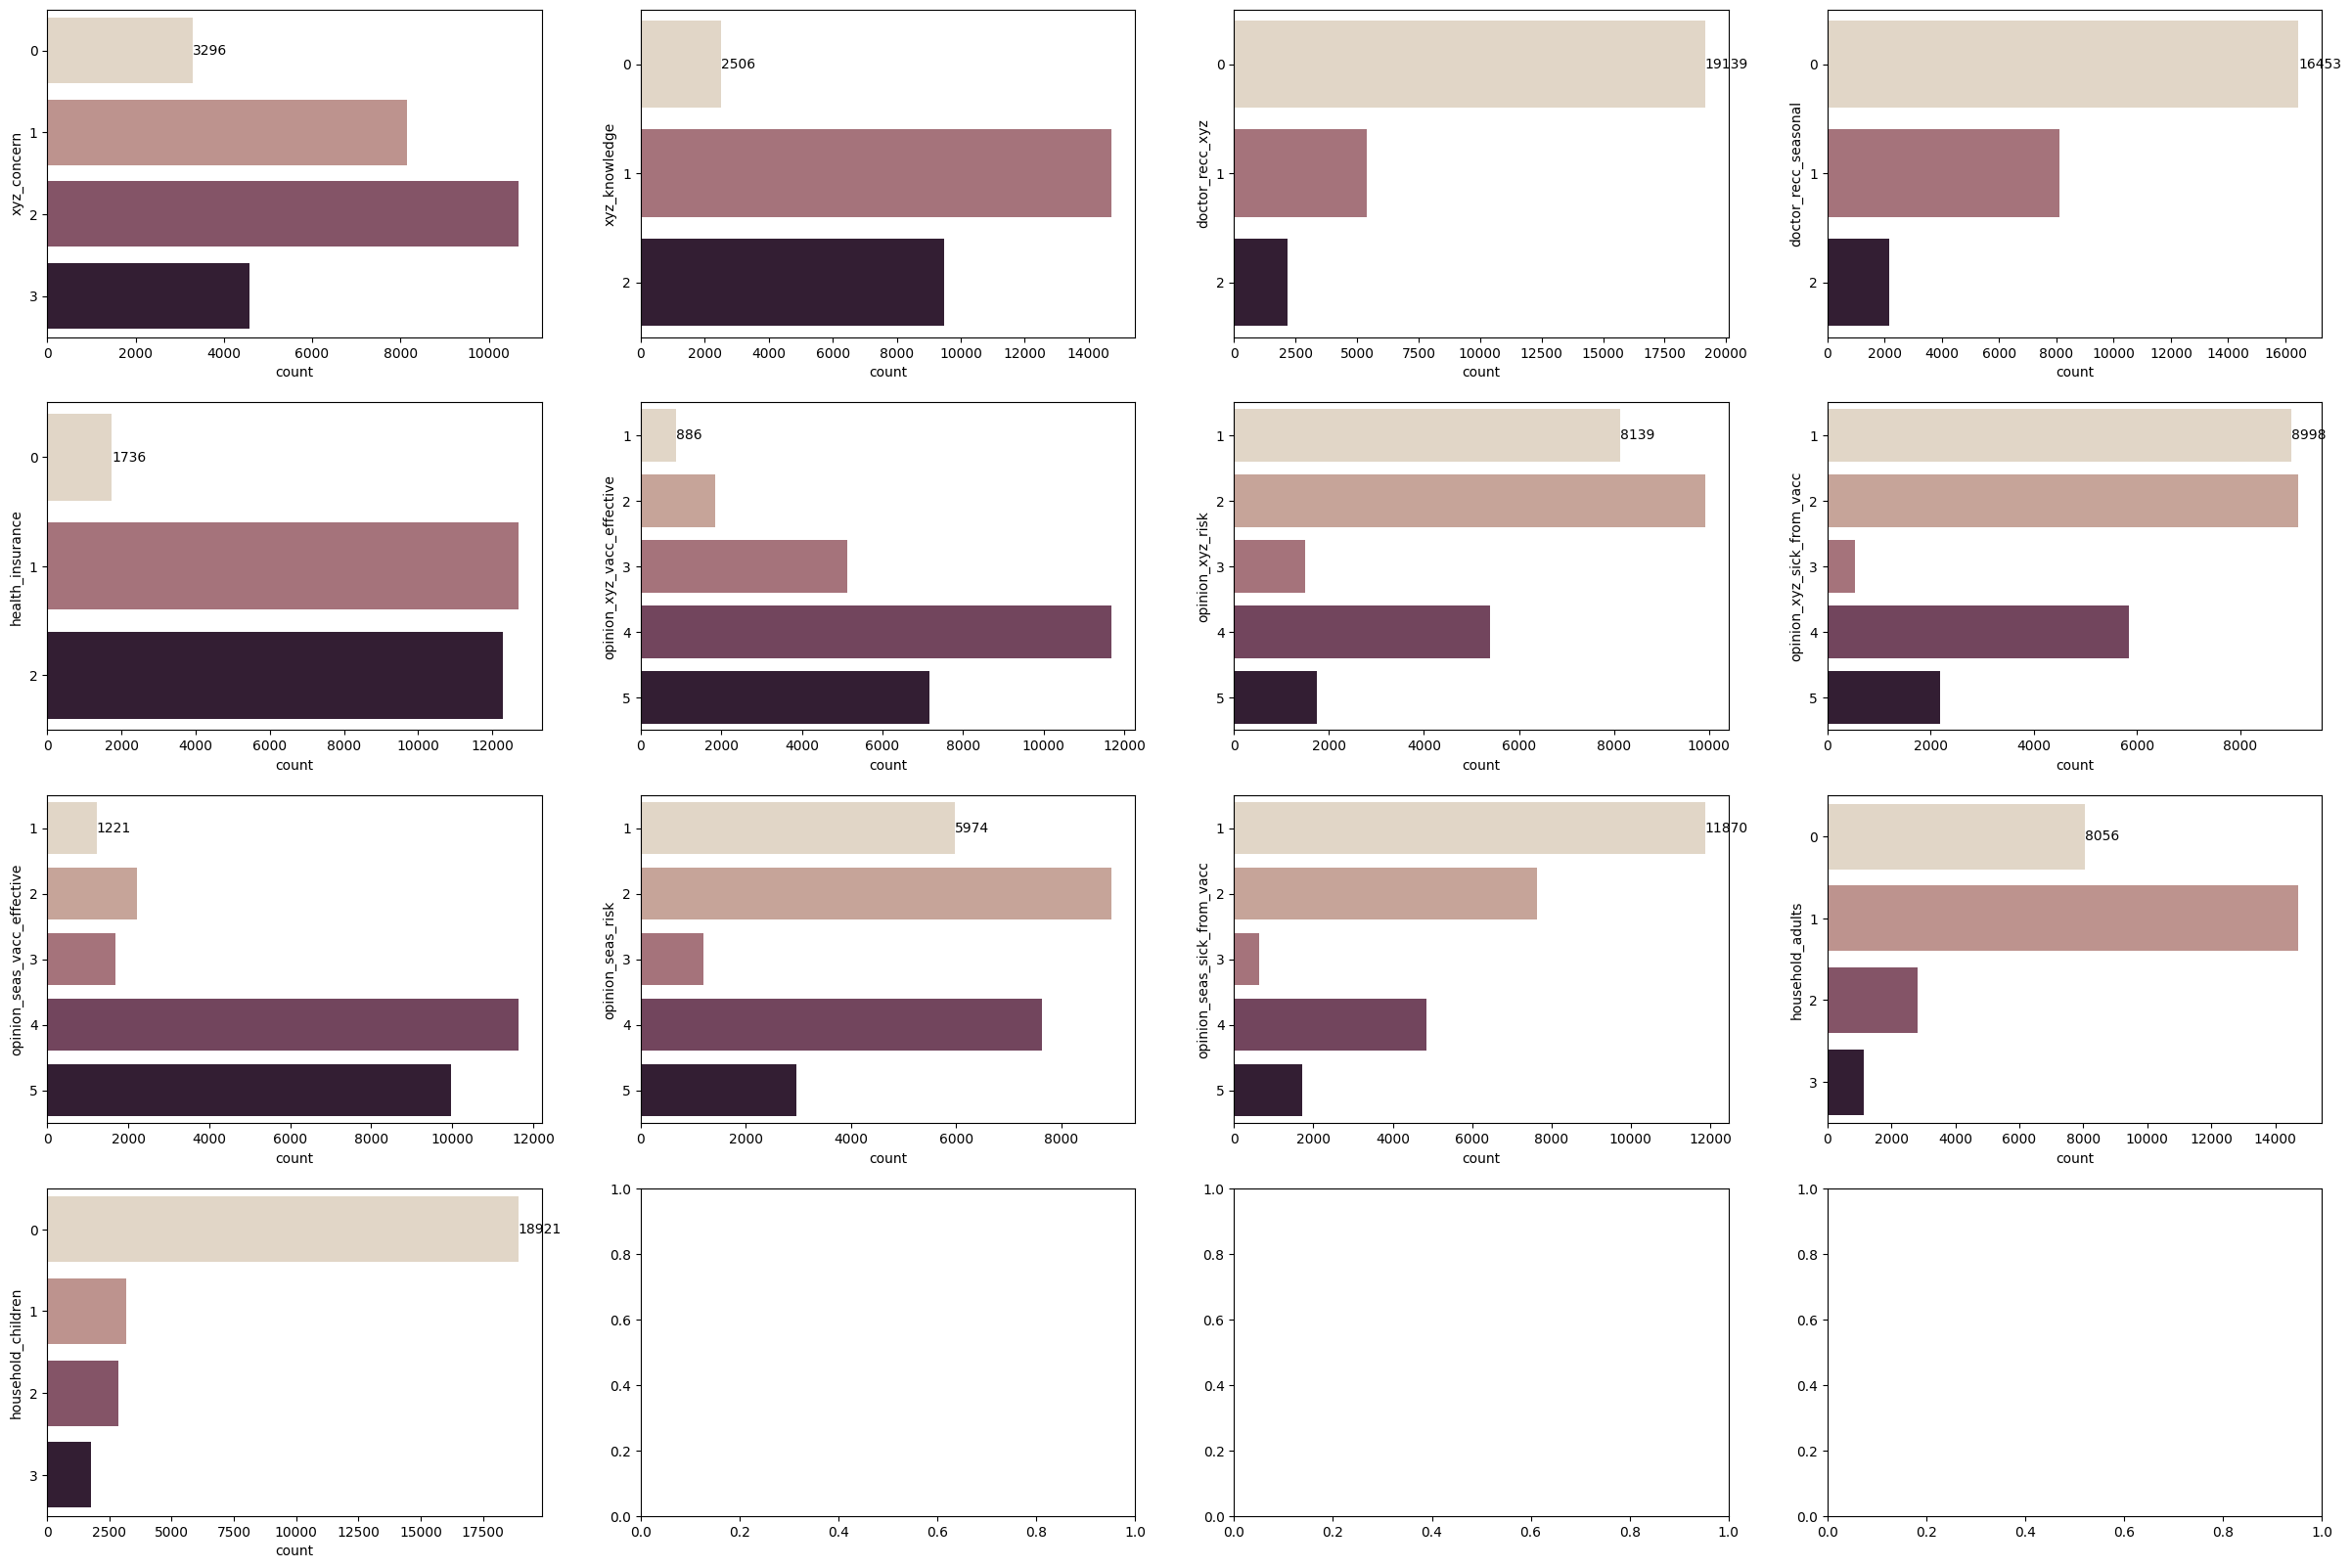

In [30]:
# Select the ordinal columns (non-binary) with more than 2 unique values.
non_binary_cols = [col for col in ordinal_cols if train[col].nunique() > 2]

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(30, 20))  # Creating subplots for countplots with specified dimensions and figure size.

for i, col in enumerate(non_binary_cols):  # Iterate over the non-binary ordinal columns.
    bar = sns.countplot(data=train, y=col, ax=ax[i//4, i%4], palette="ch:.25")  # Create a countplot for each column and assign it to the corresponding subplot.
    bar.bar_label(bar.containers[0])  # Add labels to the bars in the countplot.

<ipython-input-31-ddf454863bd9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.countplot(data=train, y=col, ax=ax[i//4, i%4], palette="coolwarm")
<ipython-input-31-ddf454863bd9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.countplot(data=train, y=col, ax=ax[i//4, i%4], palette="coolwarm")
<ipython-input-31-ddf454863bd9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.countplot(data=train, y=col, ax=ax[i//4, i%4], palette="coolwarm")
<ipython-input-31-ddf454863bd9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

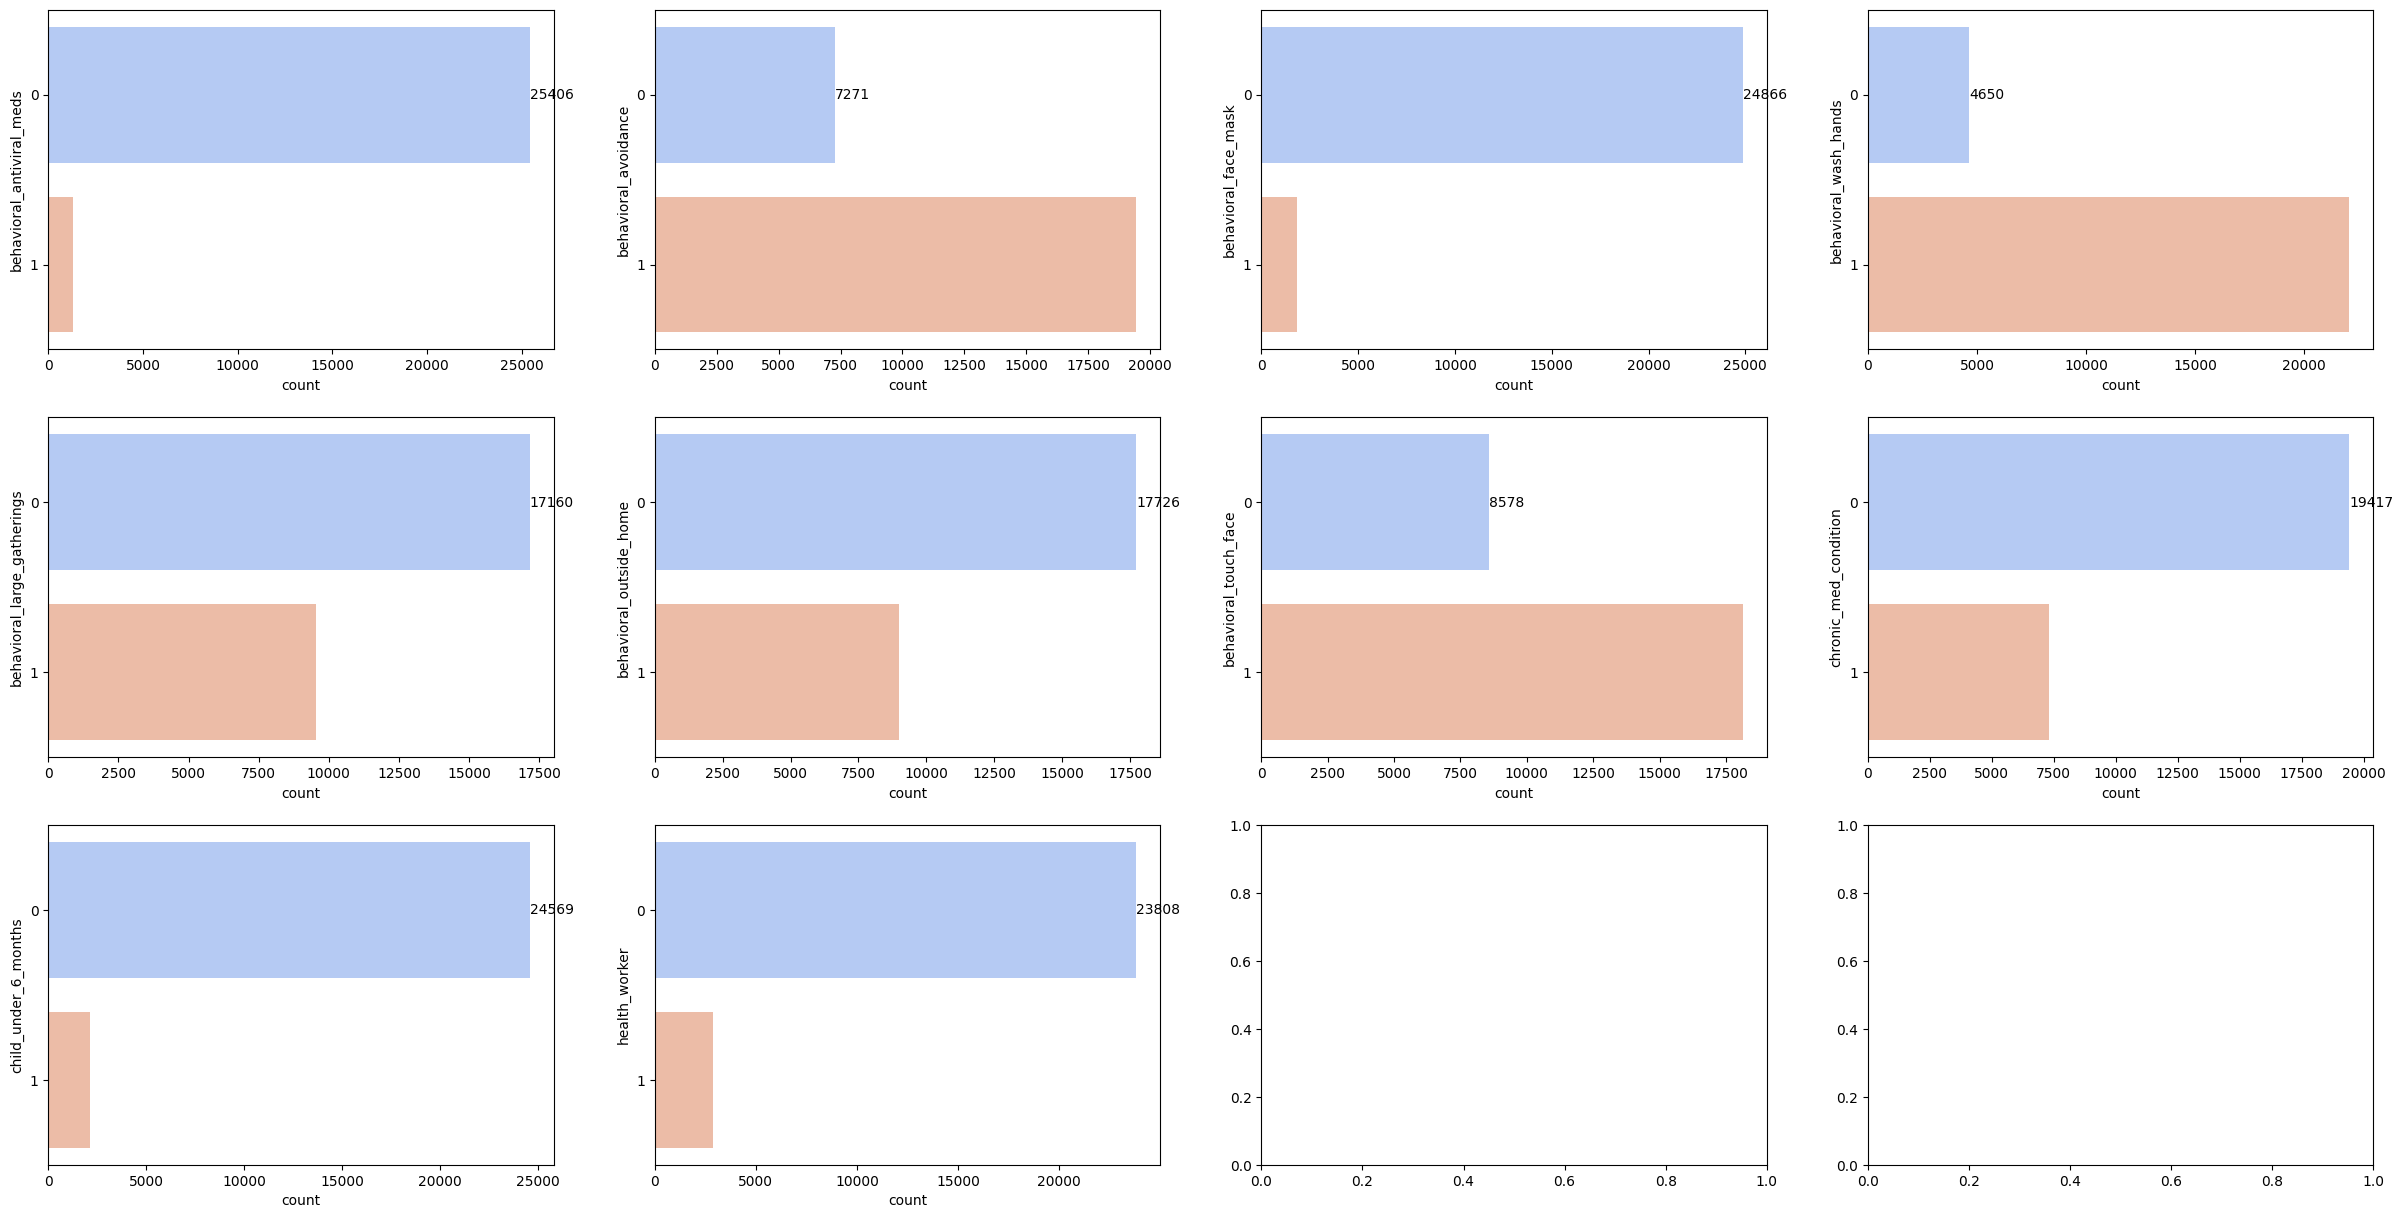

In [31]:
# Select the ordinal columns (binary) with less than or equal to 2 unique values.
binary_cols = [col for col in ordinal_cols if train[col].nunique() <= 2]

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))

for i, col in enumerate(binary_cols):
  bar = sns.countplot(data=train, y=col, ax=ax[i//4, i%4], palette="coolwarm")
  bar.bar_label(bar.containers[0])

Considering that the "None" category overwhelmingly dominates all other categories in the `employment_industry` and `employment_occupation` columns, it is apparent that plotting these columns would not yield any valuable insights. Therefore, we will exclude them from our analysis.

<ipython-input-32-a1a6964ed92b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.countplot(data=train, x=col, ax=ax[i//3, i%3], palette="rainbow")
<ipython-input-32-a1a6964ed92b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.countplot(data=train, x=col, ax=ax[i//3, i%3], palette="rainbow")
<ipython-input-32-a1a6964ed92b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.countplot(data=train, x=col, ax=ax[i//3, i%3], palette="rainbow")
<ipython-input-32-a1a6964ed92b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and 

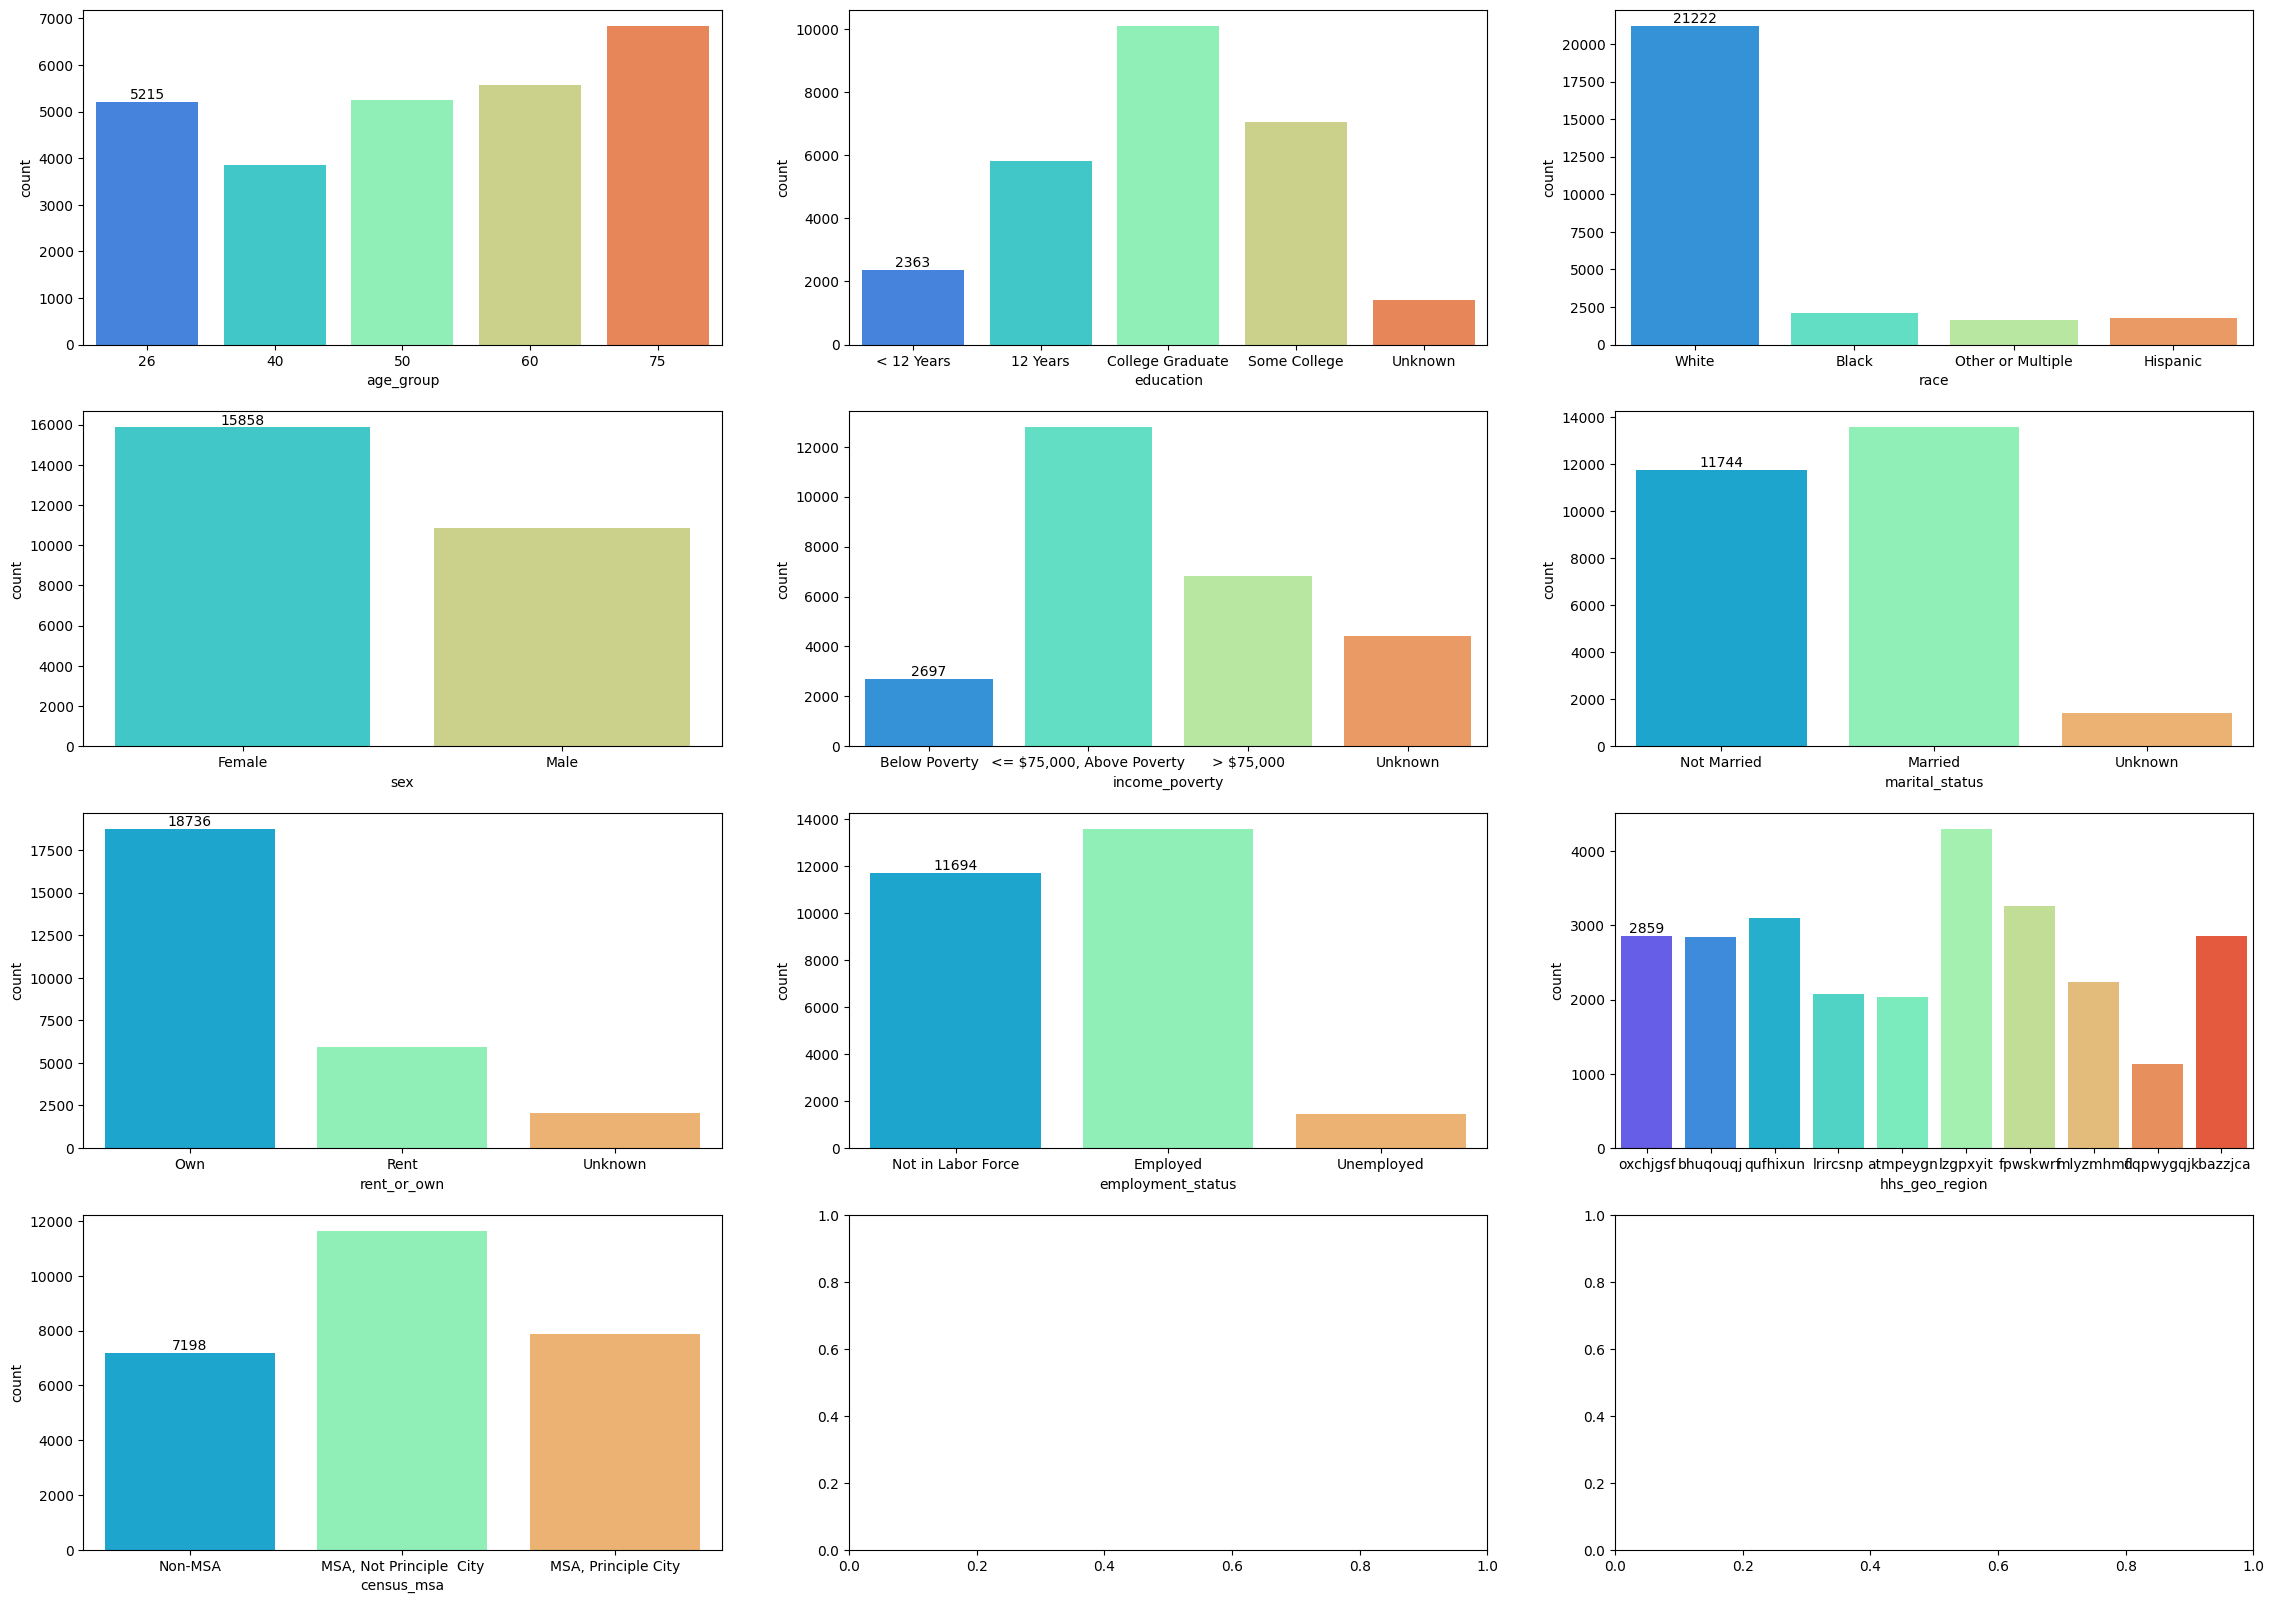

In [32]:
# Countplot for Object columns
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(28, 20))

for i, col in enumerate(object_cols):
    if (col not in ["employment_industry", "employment_occupation"]):
        bar = sns.countplot(data=train, x=col, ax=ax[i//3, i%3], palette="rainbow")
        bar.bar_label(bar.containers[0])

### **2.2. Bivariate PLots**


<ipython-input-33-47cbffd68787>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y=col, x="chronic_med_condition", ax=ax[i//4, i%4], palette="rainbow")
<ipython-input-33-47cbffd68787>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y=col, x="chronic_med_condition", ax=ax[i//4, i%4], palette="rainbow")
<ipython-input-33-47cbffd68787>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y=col, x="chronic_med_condition", ax=ax[i//4, i%4], palette="rainbow")
<ipython-input-33-47cbffd68787>:4: Fu

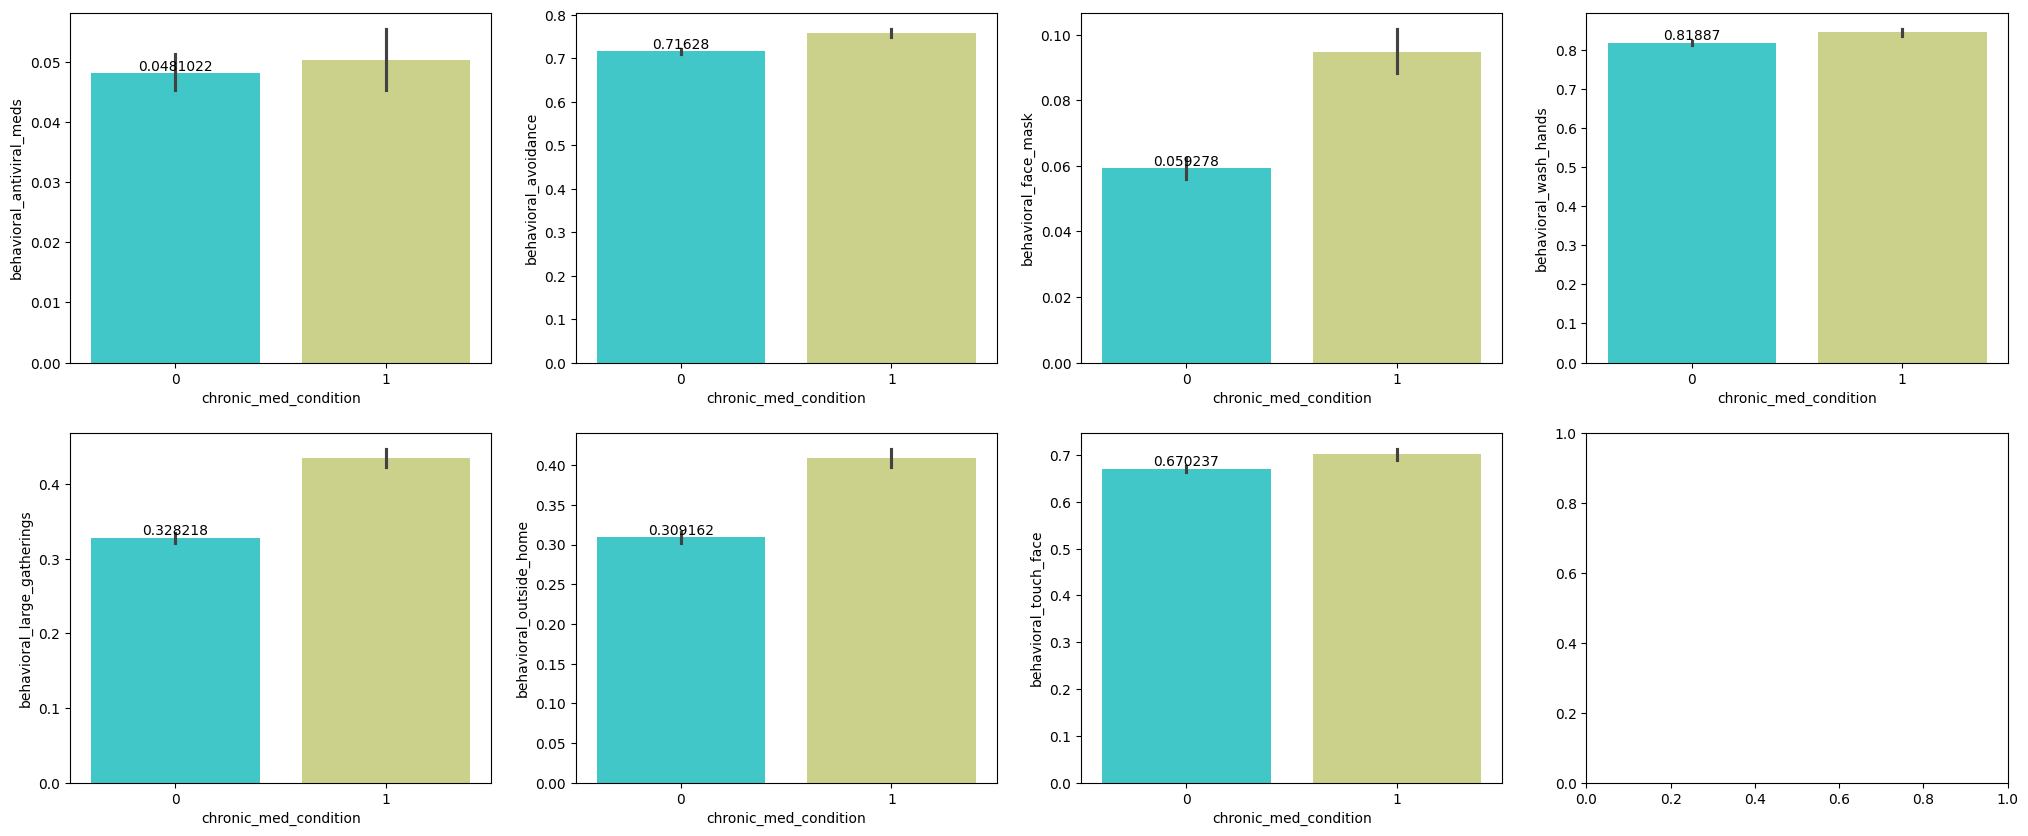

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))

for i, col in enumerate(behavioral_cols):
    bar = sns.barplot(data=train, y=col, x="chronic_med_condition", ax=ax[i//4, i%4], palette="rainbow")
    bar.bar_label(bar.containers[0])

<ipython-input-34-a8b88c09e6db>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 0], palette="Paired")
<ipython-input-34-a8b88c09e6db>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 1], palette="Paired")
<ipython-input-34-a8b88c09e6db>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 2], palette="Paired")
<ipython-input-34-a8b88c09e6db>:16: FutureWarning: 

Passing `palette` without as

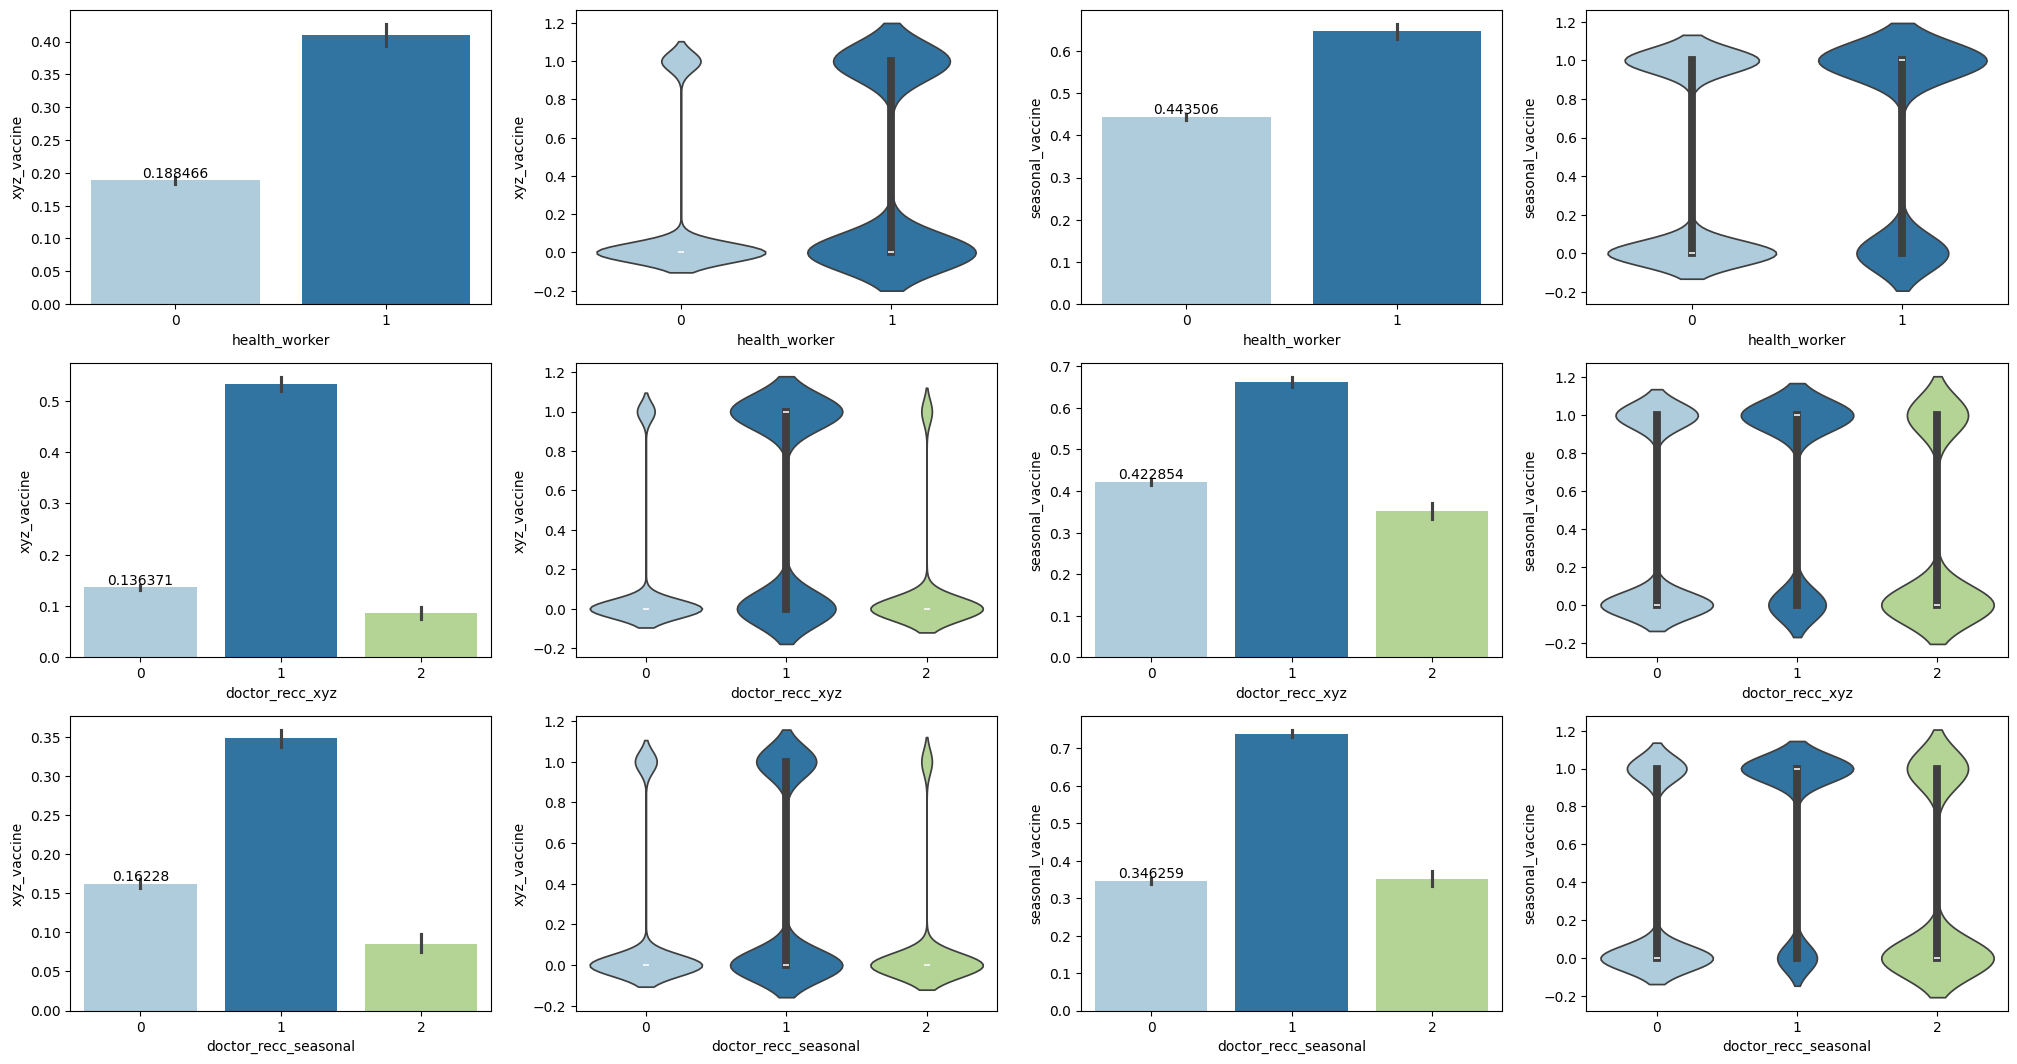

In [34]:
# Create a figure with subplots to plot the barplots and violinplots.
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(25, 13))

# Health related columns
for i, col in enumerate(["health_worker", "doctor_recc_xyz", "doctor_recc_seasonal"]):
    bar = sns.barplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 0], palette="Paired")
    bar.bar_label(bar.containers[0])

    # Plot a violinplot for 'xyz_vaccine' on the i-th subplot.
    sns.violinplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 1], palette="Paired")

    bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 2], palette="Paired")
    bar.bar_label(bar.containers[0])

    # Plot a violinplot for 'seasonal_vaccine' on the i-th subplot.
    sns.violinplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 3], palette="Paired")

Healthcare workers are more likely to receive both the xyz flu vaccine and the seasonal flu vaccine.

 Similarly, individuals recommended the xyz vaccine by a doctor are highly likely to receive both the xyz vaccine and the seasonal vaccine. Moreover, those recommended the seasonal vaccine are also highly likely to receive both the seasonal and xyz vaccines.

<ipython-input-35-6379d4892699>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 0], palette="rainbow")
<ipython-input-35-6379d4892699>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 1], palette="rainbow")
<ipython-input-35-6379d4892699>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 0], palette="rainbow")
<ipython-input-35-6379d4892699>:9: FutureWarning: 

Passing `palette` without assigni

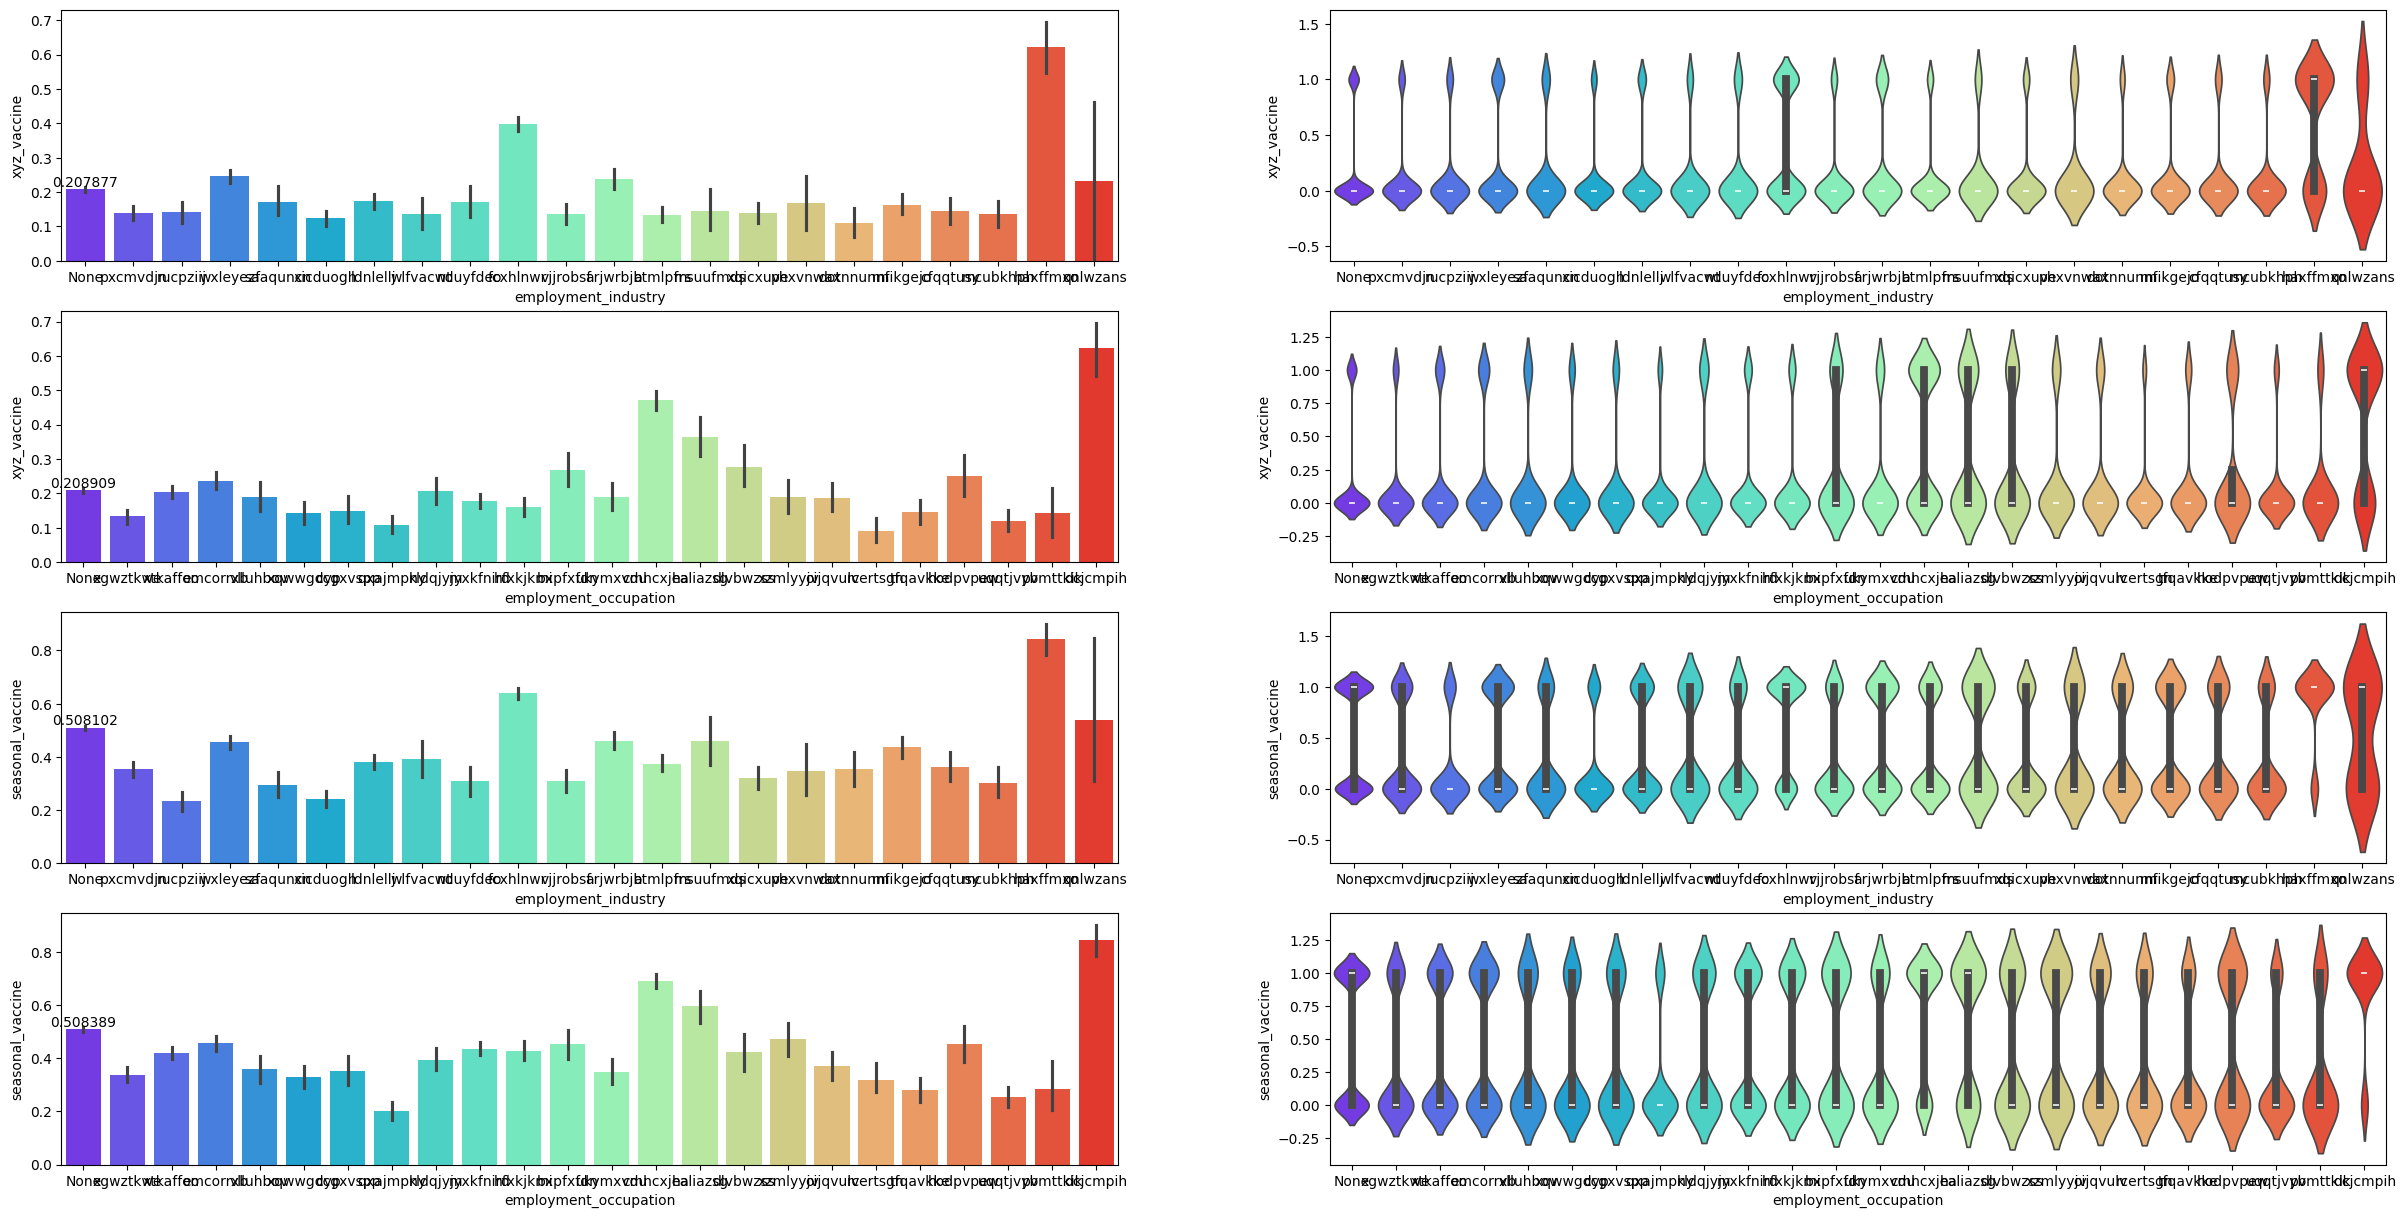

In [35]:
# Create a figure with subplots to plot the barplots and violinplots.
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))

# Employment related columns
# Create barplots and violinplots for 'xyz_vaccine' for each column.
for i, col in enumerate(["employment_industry", "employment_occupation"]):
    bar = sns.barplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 0], palette="rainbow")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 1], palette="rainbow")

# Create barplots and violinplots for 'seasonal_vaccine' for each column.
for i, col in enumerate(["employment_industry", "employment_occupation"]):
    bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i+2, 0], palette="rainbow")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i+2, 1], palette="rainbow")

<ipython-input-36-9fefbec00e5f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 0], palette="Spectral")
<ipython-input-36-9fefbec00e5f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 1], palette="Spectral")
<ipython-input-36-9fefbec00e5f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 2], palette="Spectral")
<ipython-input-36-9fefbec00e5f>:12: FutureWarning: 

Passing `palette` witho

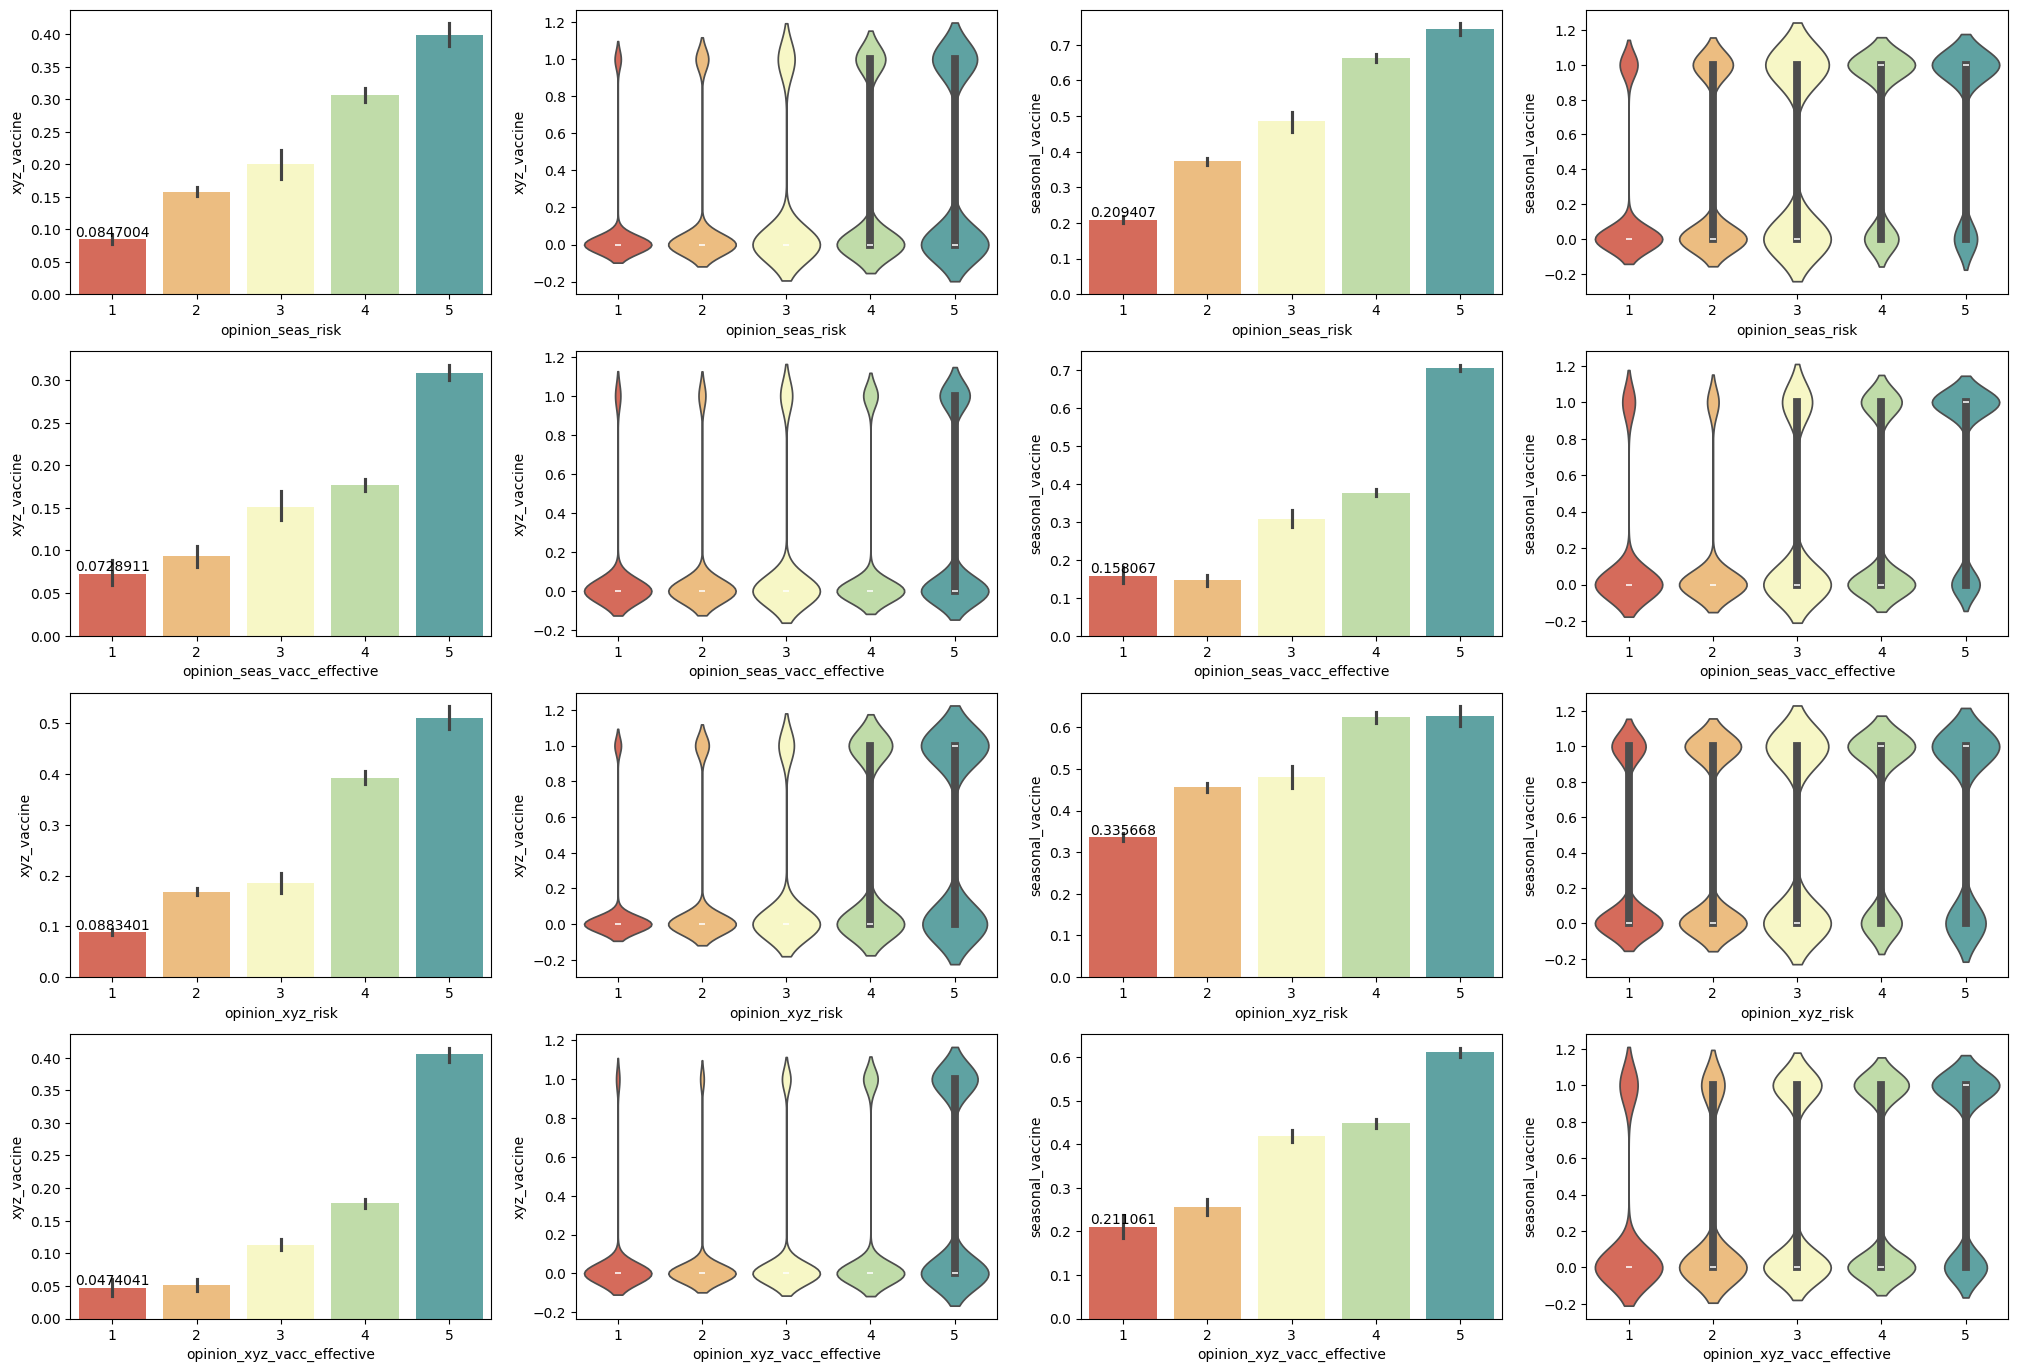

In [36]:
# Create a figure with subplots to plot the barplots and violinplots.
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(25, 17))

# Opinion related columns
for i, col in enumerate(["opinion_seas_risk", "opinion_seas_vacc_effective", "opinion_xyz_risk", "opinion_xyz_vacc_effective"]):
    bar = sns.barplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 0], palette="Spectral")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='xyz_vaccine', x=col, ax=ax[i, 1], palette="Spectral")

    bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 2], palette="Spectral")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 3], palette="Spectral")

<ipython-input-37-d53cc613db3d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 0], palette="coolwarm")
<ipython-input-37-d53cc613db3d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 1], palette="coolwarm")
<ipython-input-37-d53cc613db3d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 0], palette="coolwarm")
<ipython-input-37-d53cc613db3d>:7: FutureWarning: 

Passing `palett

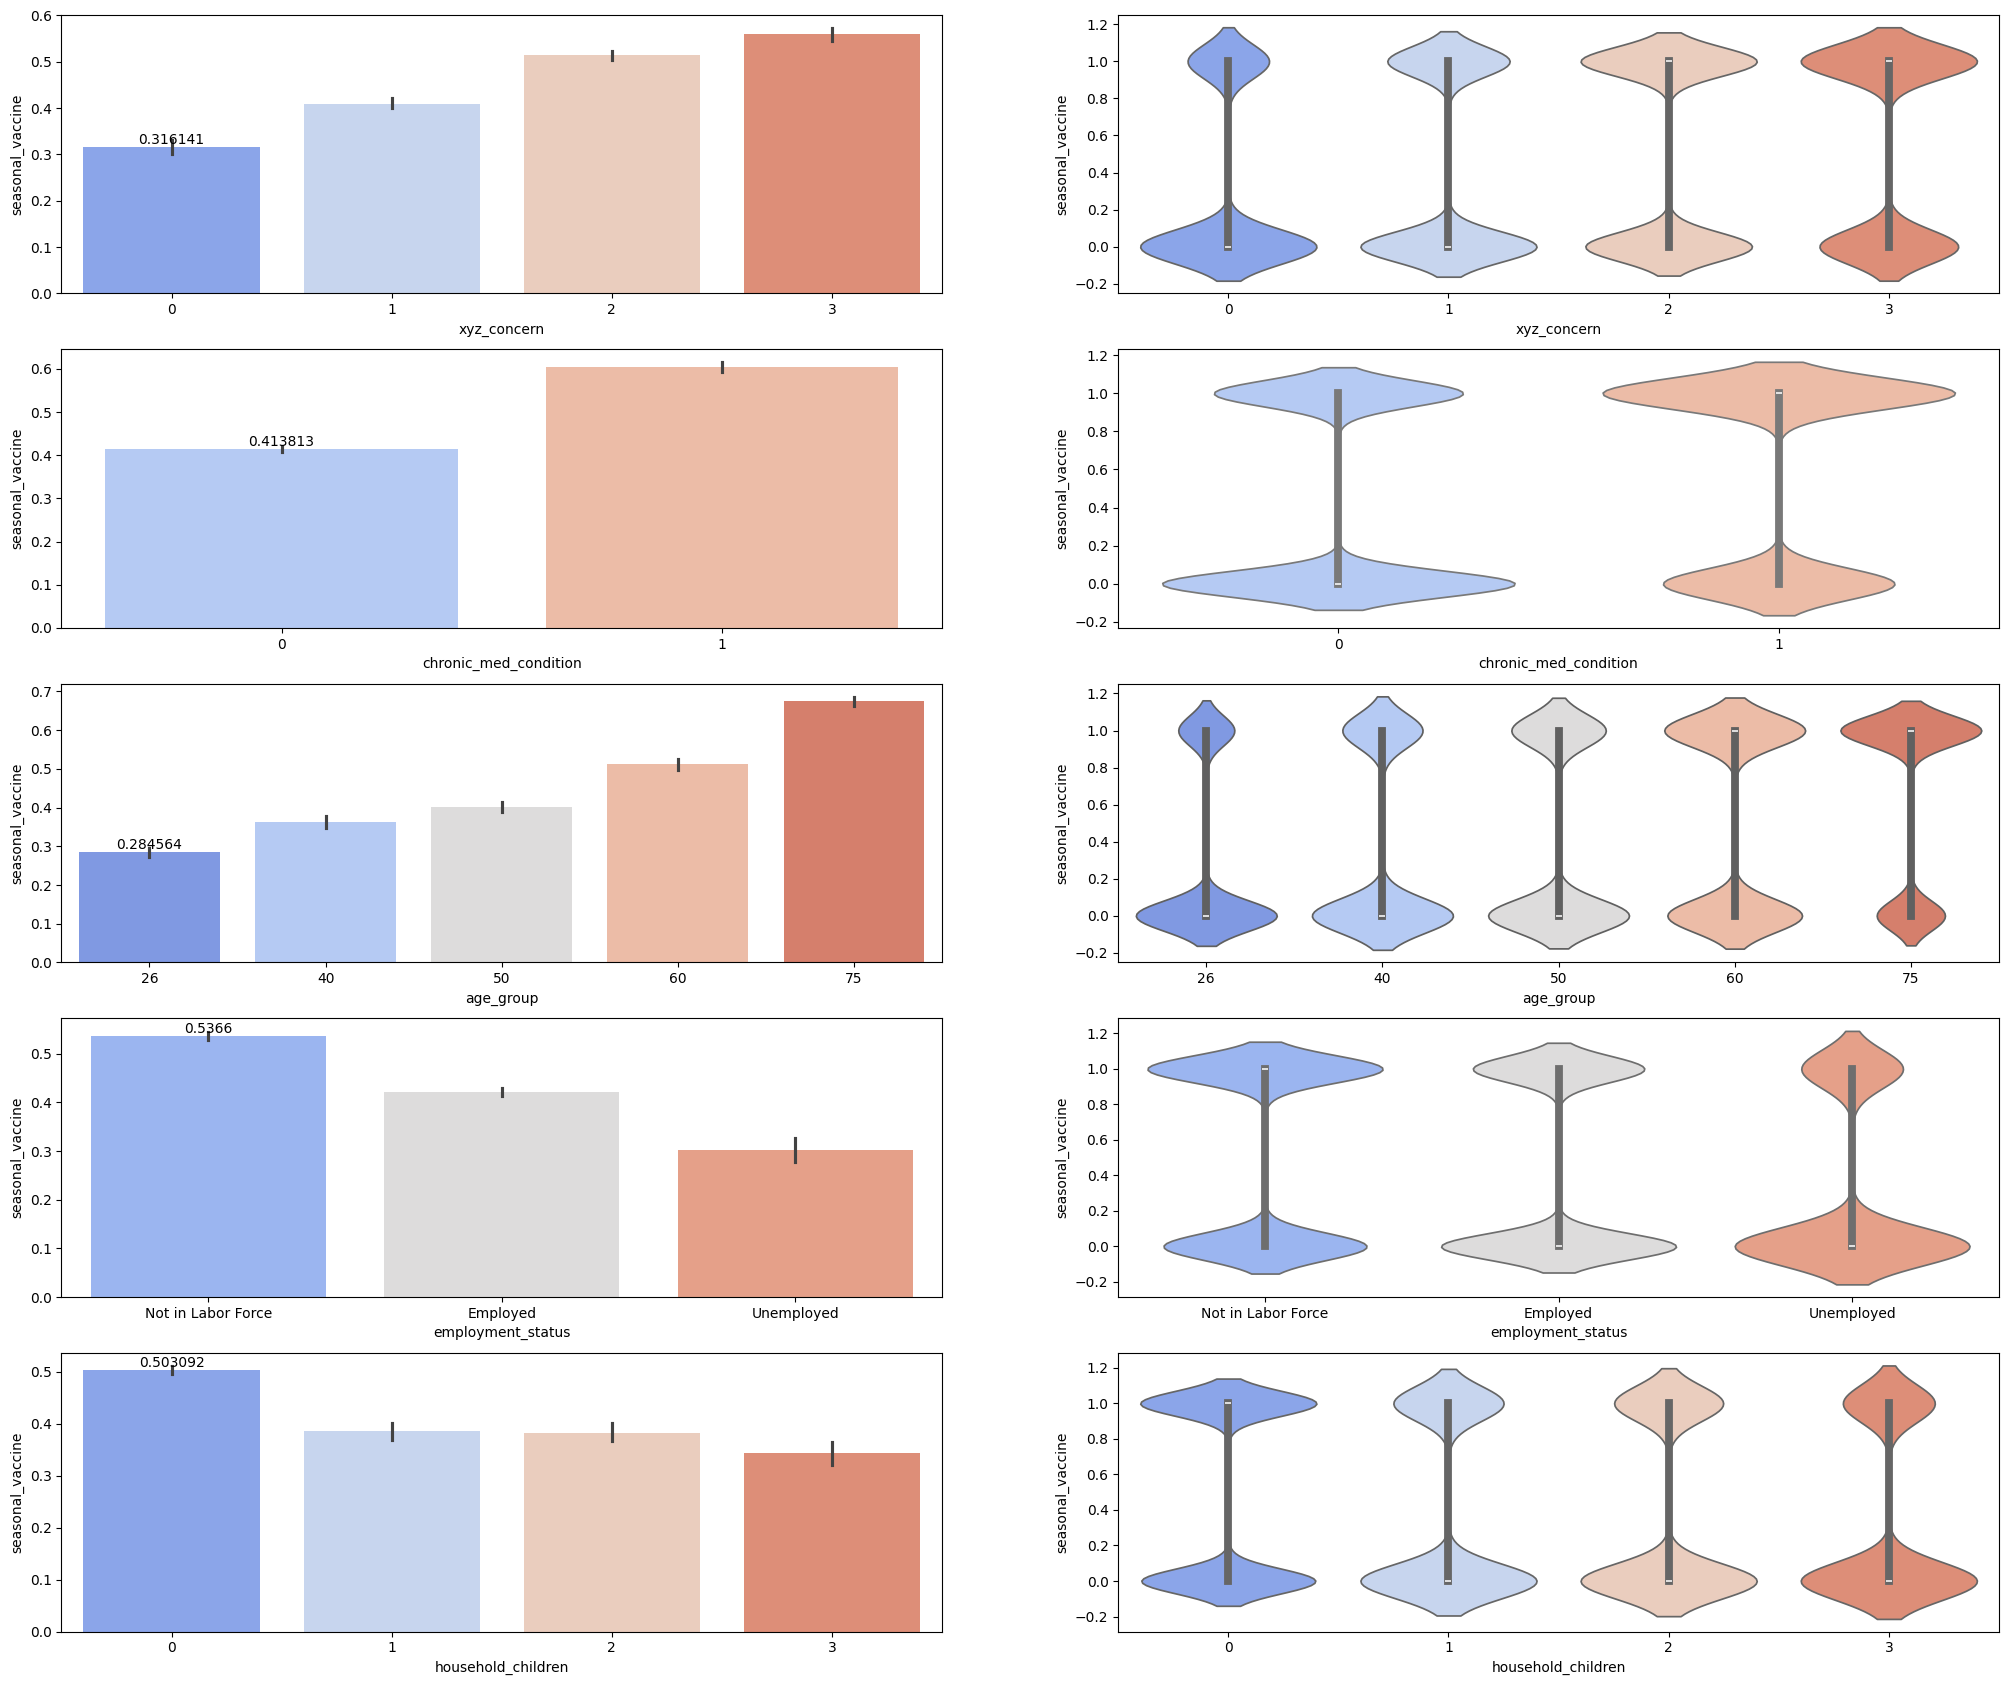

In [37]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(25, 21))

# Other interesting columns
for i, col in enumerate(["xyz_concern", "chronic_med_condition", "age_group", "employment_status", "household_children"]):
    bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 0], palette="coolwarm")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 1], palette="coolwarm")

### **Conclusions:**
1. Individuals with chronic medical conditions are more likely to adopt preventive measures against flu-like illnesses.

2. Certain industries and occupations exhibit higher vaccination rates for both the XYZ vaccine and the seasonal flu vaccine.

3. Healthcare professionals are more likely to receive both vaccines.

4. Recommendations from doctors significantly influence vaccine uptake.

5. Perceived vaccine effectiveness and the perceived risk of illness are crucial factors.

# **3. Feature Engineering**
To enhance the predictive performance of our model, we will create additional relevant features that capture important patterns and relationships in the data. We propose the following new features:

* `good_behavioral_count` -- represent the cumulative count of flu precaution behaviors practiced by an individual.

* `has_doc_recc` -- indicate whether a person has received a recommendation from a doctor for either the xyz vaccine or the seasonal flu vaccine (binary). 1:Yes 2: NO

In [38]:
for df in [train, test]:
    # Calculate the sum of behavioral columns and create a new column "good_behavioral_count"
    df["good_behavioral_count"] = df[behavioral_cols].sum(axis=1)

    for i in range(df.index[0], df.index[-1]+1):
        # Check if both "doctor_recc_xyz" and "doctor_recc_seasonal" columns have a value of 2 (Unknown)
        if df.loc[i, ["doctor_recc_xyz", "doctor_recc_seasonal"]].isin([2]).all():
            # If both columns have a value of 2, set "has_doc_recc" to 0
            df.loc[i, "has_doc_recc"] = 0
        else:
            # If any of the columns have a value other than 2, set "has_doc_recc" to 1
            df.loc[i, "has_doc_recc"] = 1

In [39]:
# Append the new ordinal feature to the list of ordinal columns
for new_ord_feature in ["good_behavioral_count", "has_doc_recc"]:
    ordinal_cols.append(new_ord_feature)

In [40]:
# Get the number of rows in the train dataframe
train_rows = train.shape[0]

# Concatenate the train and test dataframes vertically
merged_df = pd.concat([train, test])

# Encode object columns using Ordinal Encoding
for col in ["age_group", "education"]:
  merged_df[col], _ = merged_df[col].factorize()

# Encode object columns using One-Hot Encoding
merged_df = pd.get_dummies(merged_df, columns=["race", "sex", "marital_status", "rent_or_own", "employment_status", "hhs_geo_region",
                                               "census_msa", "employment_industry", "employment_occupation", "income_poverty"])

# Separate the merged dataframe back into train and test dataframes
train = merged_df.iloc[:train_rows]
test = merged_df.iloc[train_rows:].drop(columns=["xyz_vaccine", "seasonal_vaccine"])

In [41]:
train.head()

,xyz_concern,xyz_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_xyz,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_xyz_vacc_effective,opinion_xyz_risk,opinion_xyz_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,xyz_vaccine,seasonal_vaccine,good_behavioral_count,has_doc_recc,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,marital_status_Married,marital_status_Not Married,marital_status_Unknown,rent_or_own_Own,rent_or_own_Rent,rent_or_own_Unknown,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_None,employment_industry_arjwrbjb,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_None,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_Unknown
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,3,1,2,2,1,2,0,0,0,0,0.0,0.0,2,1.0,False,False,False,True,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,3,2,0,1,0,1,0,1,1,0,0,0,0,0,1,5,4,4,4,2,4,1,1,0,0,0.0,1.0,4,1.0,False,False,False,True,False,True,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False
2,1,1,0,1,0,0,0,0,0,2,2,1,0,0,2,3,1,1,4,1,2,2,2,2,0,0.0,0.0,1,0.0,False,False,False,True,False,True,False,True,False,True,False,False,True,Fa

In [42]:
# Mutual Information function to calculate MI scores
def make_mi_scores(X, y, discrete_features):
    # Calculate Mutual Information (MI) scores between features (X) and target (y)
    mi_scores = mic(X, y, discrete_features=discrete_features)
    # Convert the MI scores to a Pandas Series with feature names as index and sort in descending order
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)
    return mi_scores

# Create a copy of the train dataframe as X
X = train.copy()

# Separate the target variables from X and store them in y_xyz and y_seas
y_xyz = X.pop("xyz_vaccine")
y_seas = X.pop("seasonal_vaccine")

# Identify the discrete features in X (features with dtype 'int64')
discrete_features = (X.dtypes == "int64")

In [43]:
# xyz MI Score
mi_scores_xyz = make_mi_scores(X, y_xyz, discrete_features)

# Convert the MI scores into a transposed DataFrame
pd.DataFrame(mi_scores_xyz).T

,doctor_recc_xyz,opinion_xyz_risk,opinion_xyz_vacc_effective,opinion_seas_risk,health_insurance,doctor_recc_seasonal,opinion_seas_vacc_effective,employment_industry_fcxhlnwr,health_worker,employment_occupation_cmhcxjea,xyz_concern,has_doc_recc,xyz_knowledge,race_White,employment_status_Not in Labor Force,hhs_geo_region_lzgpxyit,rent_or_own_Own,employment_status_Unemployed,opinion_xyz_sick_from_vacc,chronic_med_condition,rent_or_own_Unknown,good_behavioral_count,employment_industry_ldnlellj,sex_Male,race_Other or Multiple,"income_poverty_> $75,000",employment_occupation_xzmlyyjv,employment_occupation_xgwztkwe,employment_occupation_dlvbwzss,employment_industry_None,employment_industry_msuufmds,behavioral_wash_hands,hhs_geo_region_dqpwygqj,employment_occupation_None,behavioral_touch_face,employment_status_Employed,education,employment_industry_pxcmvdjn,race_Black,hhs_geo_region_atmpeygn,behavioral_face_mask,race_Hispanic,child_under_6_months,sex_Female,employment_industry_haxffmxo,employment_industry_rucpziij,marital_status_Married,employment_occupation_ukymxvdu,employment_occupation_ccgxvspp,age_group,employment_industry_mfikgejo,employment_occupation_qxajmpny,rent_or_own_Rent,behavioral_avoidance,marital_status_Not Married,employment_industry_saaquncn,hhs_geo_region_oxchjgsf,opinion_seas_sick_from_vacc,employment_industry_dotnnunm,hhs_geo_region_kbazzjca,employment_industry_vjjrobsf,behavioral_antiviral_meds,employment_occupation_bxpfxfdn,employment_industry_qnlwzans,employment_industry_atmlpfrs,household_adults,income_poverty_Unknown,behavioral_outside_home,employment_occupation_haliazsg,behavioral_large_gatherings,"income_poverty_<= $75,000, Above Poverty",employment_occupation_hfxkjkmi,"census_msa_MSA, Not Principle City",household_children,employment_industry_wxleyezf,employment_occupation_tfqavkke,employment_occupation_pvmttkik,hhs_geo_region_bhuqouqj,employment_occupation_rcertsgn,employment_occupation_vlluhbov,marital_status_Unknown,employment_occupation_uqqtjvyb,employment_occupation_mxkfnird,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,income_poverty_Below Poverty,employment_occupation_oijqvulv,employment_industry_phxvnwax,employment_occupation_kldqjyjy,employment_industry_xqicxuve,employment_industry_mcubkhph,employment_industry_cfqqtusy,employment_industry_arjwrbjb,census_msa_Non-MSA,employment_industry_wlfvacwt,employment_industry_xicduogh,"census_msa_MSA, Principle City",employment_industry_nduyfdeo,hhs_geo_region_qufhixun,hhs_geo_region_mlyzmhmf,hhs_geo_region_lrircsnp,employment_occupation_dcjcmpih,hhs_geo_region_fpwskwrf,employment_occupation_emcorrxb,employment_occupation_hodpvpew
MI Scores,0.068163,0.050324,0.044591,0.033334,0.030916,0.024471,0.019502,0.013305,0.012285,0.007902,0.007561,0.007463,0.007319,0.007095,0.007045,0.006479,0.005037,0.004854,0.004543,0.004286,0.004253,0.004246,0.004214,0.004008,0.003982,0.003874,0.003846,0.00379,0.003582,0.003326,0.003242,0.002985,0.002794,0.002593,0.002585,0.002493,0.002444,0.002423,0.00232,0.002275,0.00226,0.002095,0.002052,0.002014,0.001935,0.001758,0.001684,0.001663,0.001409,0.001293,0.00128,0.001196,0.001141,0.001124,0.00107,0.001062,0.001031,0.000859,0.000787,0.000787,0.000771,0.000755,0.000753,0.000737,0.000564,0.000531,0.000314,0.000242,0.000192,0.000163,0.000129,0.00012,0.000059,0.000048,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Seasonal MI Score
mi_scores_seas = make_mi_scores(X, y_seas, discrete_features)

# Convert the MI scores into a transposed DataFrame
pd.DataFrame(mi_scores_seas).T

,opinion_seas_vacc_effective,opinion_seas_risk,doctor_recc_seasonal,age_group,opinion_xyz_risk,opinion_xyz_vacc_effective,doctor_recc_xyz,sex_Female,chronic_med_condition,health_insurance,xyz_concern,race_White,good_behavioral_count,employment_industry_ldnlellj,rent_or_own_Own,health_worker,employment_occupation_None,xyz_knowledge,behavioral_touch_face,employment_industry_fcxhlnwr,rent_or_own_Rent,household_children,employment_status_Employed,employment_status_Not in Labor Force,behavioral_wash_hands,"income_poverty_> $75,000",sex_Male,employment_occupation_ukymxvdu,race_Hispanic,employment_industry_wlfvacwt,employment_industry_xicduogh,employment_industry_pxcmvdjn,race_Black,opinion_seas_sick_from_vacc,employment_industry_cfqqtusy,hhs_geo_region_lrircsnp,employment_occupation_cmhcxjea,employment_occupation_qxajmpny,"census_msa_MSA, Principle City",employment_status_Unemployed,employment_occupation_emcorrxb,hhs_geo_region_atmpeygn,education,employment_industry_dotnnunm,employment_industry_phxvnwax,employment_occupation_dlvbwzss,behavioral_avoidance,employment_occupation_tfqavkke,employment_industry_atmlpfrs,income_poverty_Unknown,employment_industry_rucpziij,hhs_geo_region_mlyzmhmf,"income_poverty_<= $75,000, Above Poverty",household_adults,rent_or_own_Unknown,employment_occupation_xtkaffoo,employment_occupation_bxpfxfdn,behavioral_large_gatherings,employment_occupation_xqwwgdyp,employment_occupation_hodpvpew,employment_industry_haxffmxo,employment_industry_mcubkhph,behavioral_outside_home,marital_status_Not Married,hhs_geo_region_fpwskwrf,employment_industry_xqicxuve,hhs_geo_region_kbazzjca,hhs_geo_region_oxchjgsf,marital_status_Married,behavioral_face_mask,opinion_xyz_sick_from_vacc,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_industry_msuufmds,hhs_geo_region_bhuqouqj,employment_occupation_hfxkjkmi,child_under_6_months,behavioral_antiviral_meds,has_doc_recc,employment_occupation_ccgxvspp,hhs_geo_region_qufhixun,income_poverty_Below Poverty,hhs_geo_region_lzgpxyit,census_msa_Non-MSA,employment_occupation_xzmlyyjv,employment_industry_None,employment_industry_arjwrbjb,employment_occupation_xgwztkwe,employment_occupation_vlluhbov,employment_occupation_uqqtjvyb,hhs_geo_region_dqpwygqj,employment_industry_mfikgejo,employment_occupation_rcertsgn,employment_industry_nduyfdeo,marital_status_Unknown,employment_industry_qnlwzans,employment_occupation_mxkfnird,employment_occupation_kldqjyjy,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_occupation_haliazsg,employment_industry_wxleyezf,race_Other or Multiple,employment_occupation_dcjcmpih,"census_msa_MSA, Not Principle City"
MI Scores,0.082803,0.078227,0.066719,0.041567,0.024315,0.023795,0.020623,0.016463,0.014386,0.014376,0.012536,0.010479,0.009904,0.008674,0.008658,0.008104,0.008054,0.007386,0.00725,0.007169,0.007133,0.007108,0.007073,0.007009,0.006413,0.005855,0.005782,0.005573,0.005571,0.005535,0.005513,0.005067,0.004999,0.004624,0.004613,0.004576,0.004451,0.004404,0.004173,0.003947,0.003797,0.003716,0.00326,0.003223,0.003188,0.00306,0.002914,0.002892,0.002859,0.002667,0.002651,0.002637,0.002541,0.002434,0.002273,0.00217,0.002102,0.002029,0.001818,0.001752,0.001619,0.001476,0.001418,0.001389,0.001387,0.001377,0.001358,0.001355,0.001291,0.001248,0.001182,0.001112,0.000817,0.000345,0.000225,0.000119,0.00009,0.000018,0.000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **4. Modeling**
To start modeling for the classification problem, we'll choose the best model for both the xyz_vaccine and seasonal_vaccine targets.

We will test five following models:
1. Logistic Regression
2. Decision Tree Classifier
3. RandomForest Classifier
4. Gaussian Naive Bayes
5. Support Vector Classifier (SVM)

In [45]:
models = {
    "lr": LogisticRegression(random_state=42, max_iter=1000),
    "dtc": DecisionTreeClassifier(random_state=42),
    "rfc": RandomForestClassifier(random_state=42),
    "gnb": GaussianNB(),
    "svc": SVC(random_state=42),
}


In [46]:
# Function for performing k-fold cross-validation
def kfold_cv(model, X, y):
    # Define KFold cross-validation with 5 splits, random state of 42, and shuffling of data
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = []  # List to store the evaluation scores

    # Iterate over the train and validation splits
    for train_idx, test_idx in kf.split(X, y):
        # Split the data into training and validation sets based on the indices
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the validation data
        predictions = model.predict(X_val)

        # Calculate the evaluation score (here, using RAS macro-average)
        ras_score = ras(y_val, predictions, average="macro")

        # Append the score to the list of scores
        scores.append(ras_score)
    return np.mean(scores) # Return the mean of the scores as the overall evaluation score

# Prepare the input features and target variables for xyz vaccine prediction
X_xyz = train.drop(["xyz_vaccine", "seasonal_vaccine"], axis=1)
y_xyz = train.pop("xyz_vaccine")

# Prepare the input features and target variables for seasonal flu vaccine prediction
X_seas = train.drop("seasonal_vaccine", axis=1)
y_seas = train.pop("seasonal_vaccine")

### Model performances for xyz_vaccine

lr: 0.708638227284595
dtc: 0.6806853230763787
rfc: 0.694912209992445
gnb: 0.660170583324031
svc: 0.6862238701125492


<ipython-input-47-8f48ba713ea2>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Score', data=scores_df, palette='viridis')


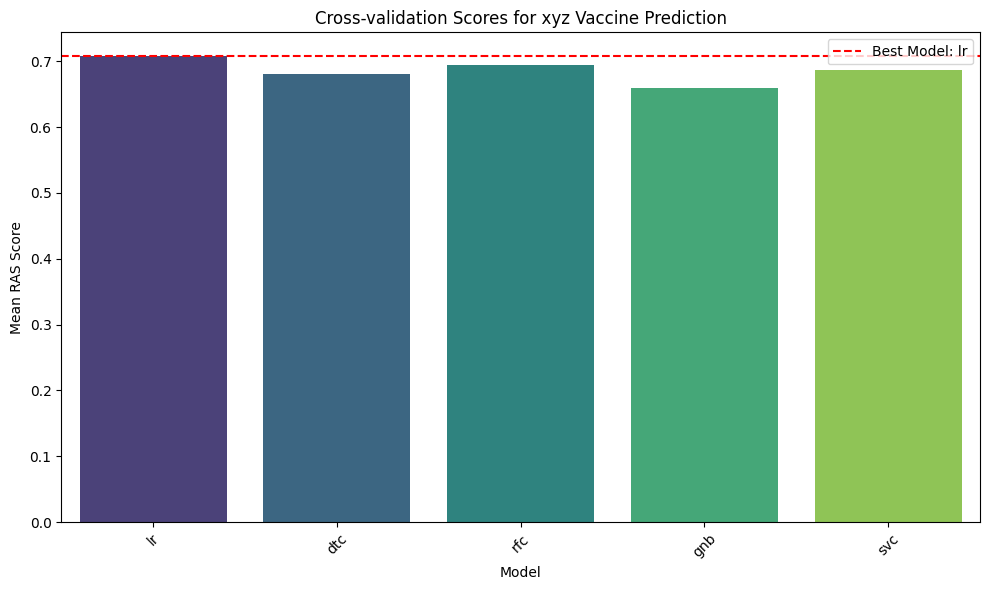

In [47]:
# Dictionary to store the scores
scores_dict = {}

# Iterate over the models dictionary
for name, model in models.items():
    # Perform k-fold cross-validation and obtain the evaluation score
    score = kfold_cv(model, X_xyz, y_xyz)
    scores_dict[name] = score  # Store the score in the dictionary
    # Print the model name and its corresponding score
    print(f"{name}: {score}")

# Convert scores_dict to a DataFrame for easier plotting
scores_df = pd.DataFrame(scores_dict.items(), columns=['Model', 'Score'])

# Plotting the scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', data=scores_df, palette='viridis')
plt.title('Cross-validation Scores for xyz Vaccine Prediction')
plt.ylabel('Mean RAS Score')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Highlight the best performing model
best_model = scores_df.loc[scores_df['Score'].idxmax()]
plt.axhline(best_model['Score'], color='red', linestyle='--', label=f'Best Model: {best_model["Model"]}')
plt.legend()

plt.tight_layout()
plt.show()


### Model Performances for Seasonal Vaccine

lr: 0.7675382269873758
dtc: 0.6818981780307172
rfc: 0.7748969419806162
gnb: 0.6473026528245842
svc: 0.7749401964035405
  Model     Score
0    lr  0.767538
1   dtc  0.681898
2   rfc  0.774897
3   gnb  0.647303
4   svc  0.774940


<ipython-input-48-635aa22c0150>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Score', data=scores_seas_df, palette='viridis')


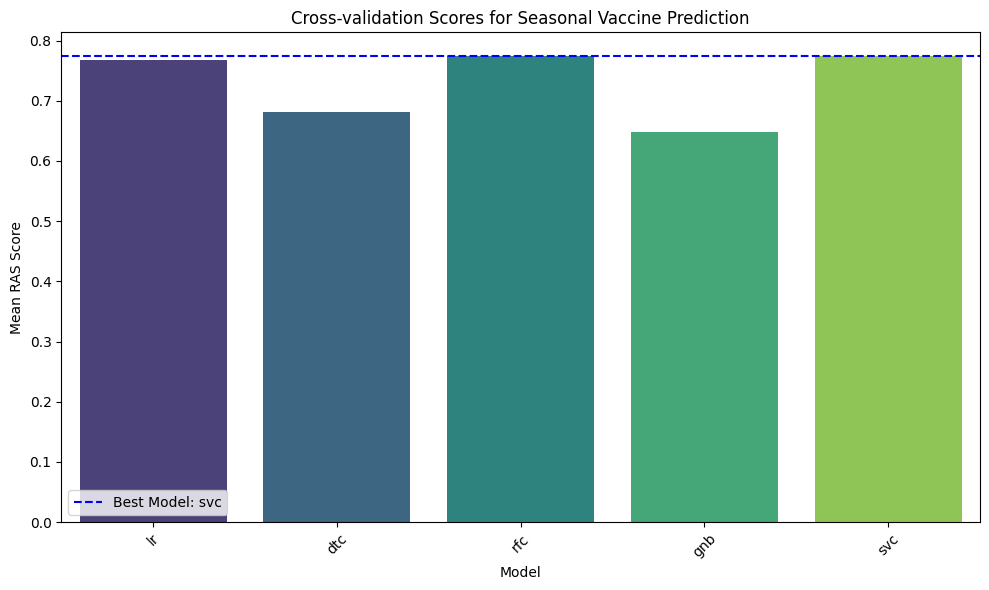

In [48]:
scores_seas_dict = {}

# Iterate over the models dictionary for seasonal vaccine prediction
for name, model in models.items():
    # Perform k-fold cross-validation and obtain the evaluation score
    score = kfold_cv(model, X_seas, y_seas)
    scores_seas_dict[name] = score  # Store the score in the dictionary
    # Print the model name and its corresponding score
    print(f"{name}: {score}")

# Convert scores_seas_dict to a DataFrame for easier plotting
scores_seas_df = pd.DataFrame(scores_seas_dict.items(), columns=['Model', 'Score'])

# Print the scores
print(scores_seas_df)

# Plotting the scores for seasonal vaccine prediction
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', data=scores_seas_df, palette='viridis')
plt.title('Cross-validation Scores for Seasonal Vaccine Prediction')
plt.ylabel('Mean RAS Score')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Highlight the best performing model
best_model_seas = scores_seas_df.loc[scores_seas_df['Score'].idxmax()]
plt.axhline(best_model_seas['Score'], color='blue', linestyle='--', label=f'Best Model: {best_model_seas["Model"]}')
plt.legend()

plt.tight_layout()
plt.show()

The results indicate that the SVC model consistently outperforms the other models, yielding comparatively better scores. This suggests that the SVC model is better suited for our classification task.

Now, we will proceed to utilize Support Vector Classifier (SVC) with tuned parameters to further enhance our prediction score. By leveraging SVC with carefully selected parameters, we aim to maximize our model’s predictive accuracy

In [49]:
# Define parameters for SVC for xyz vaccine
xyz_param_svc = {
    'C': 1.0,
    'kernel': 'rbf',
    'gamma': 'scale',
    'random_state': 42
}

# Define parameters for SVC for seasonal vaccine
seas_param_svc = {
    'C': 1.0,
    'kernel': 'rbf',
    'gamma': 'scale',
    'random_state': 42
}

# Create SVC models with tuned parameters and fit them to the data
model_xyz_svc = SVC(**xyz_param_svc)
model_xyz_svc.fit(X_xyz, y_xyz)

model_seas_svc = SVC(**seas_param_svc)
model_seas_svc.fit(X_seas, y_seas)


SVC(random_state=42)

In [50]:
score_xyz_svc = kfold_cv(model_xyz_svc, X_xyz, y_xyz)
print(f"SVC xyz: {score_xyz_svc}")

SVC xyz: 0.6862238701125492


In [51]:
score_seas_svc = kfold_cv(model_seas_svc, X_seas, y_seas)
print(f"SVC Seasonal: {score_seas_svc}")

SVC Seasonal: 0.7749401964035405


# Submission File:

In [52]:
# Use decision_function() to obtain scores for both SVC models
xyz_scores = model_xyz_svc.decision_function(test)
seas_scores = model_seas_svc.decision_function(test)

# Convert scores to probabilities using a sigmoid function
from scipy.special import expit

xyz_probabilities = expit(xyz_scores)
seas_probabilities = expit(seas_scores)

# Create a DataFrame for the submission
submission = pd.DataFrame({
    "respondent_id": test.index,  # Use the respondent IDs from the test data
    "xyz_vaccine": xyz_probabilities,  # Use the probability of the positive class for xyz vaccine
    "seasonal_vaccine": seas_probabilities  # Use the probability of the positive class for seasonal flu vaccine
})

# Save the submission DataFrame to a CSV file without including the index
submission.to_csv("submission.csv", index=False)
submission.head()


,respondent_id,xyz_vaccine,seasonal_vaccine
0,26707,0.195884,0.234168
1,26708,0.201562,0.146785
2,26709,0.389179,0.676492
3,26710,0.472618,0.747542
4,26711,0.302137,0.481914


## Confusion Matrices

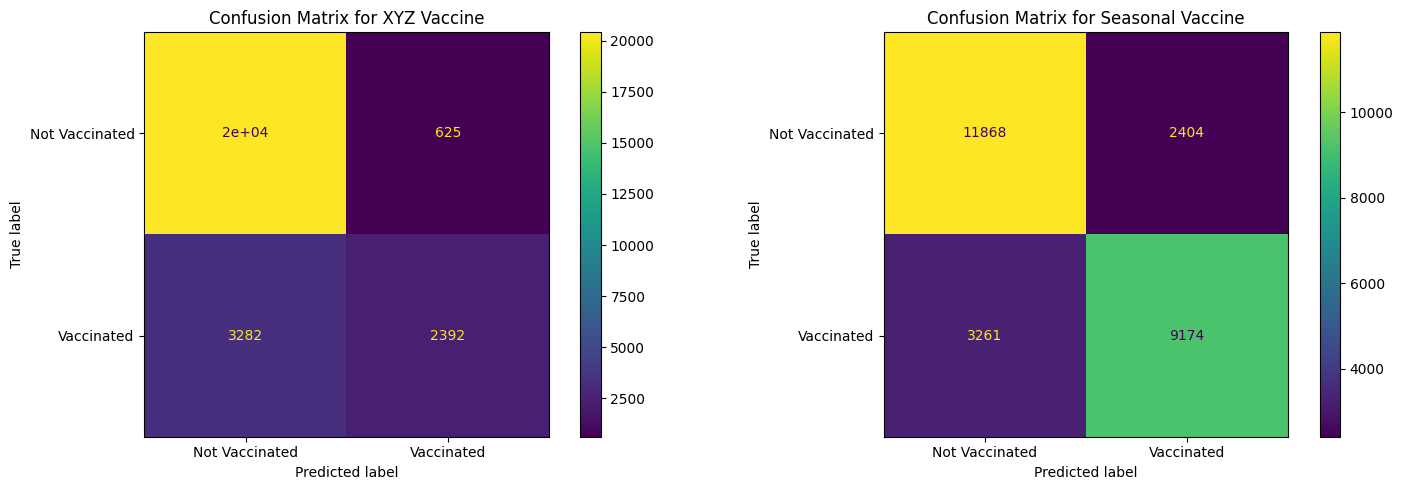

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the vaccine statuses for both vaccines using the best model (tuned SVC)
y_pred_xyz = model_xyz_svc.predict(X_xyz)
y_pred_seas = model_seas_svc.predict(X_seas)

# Calculate the confusion matrices for both vaccines
cm_xyz = confusion_matrix(y_xyz, y_pred_xyz)
cm_seas = confusion_matrix(y_seas, y_pred_seas)

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the confusion matrix for xyz vaccine
disp_xyz = ConfusionMatrixDisplay(cm_xyz, display_labels=["Not Vaccinated", "Vaccinated"])
disp_xyz.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix for XYZ Vaccine")

# Plot the confusion matrix for seasonal flu vaccine
disp_seas = ConfusionMatrixDisplay(cm_seas, display_labels=["Not Vaccinated", "Vaccinated"])
disp_seas.plot(ax=axes[1])
axes[1].set_title("Confusion Matrix for Seasonal Vaccine")

plt.tight_layout()
plt.show()


<br><br>
<hr><hr>